In [6]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import math
from numpy import diff
from tqdm import tqdm
from scipy import interpolate
from scipy.interpolate import interp1d
from pycbc.types import TimeSeries, FrequencySeries
from lal import MSUN_SI, MTSUN_SI, G_SI, PC_SI, C_SI
import scipy.optimize
import lal
from pycbc import waveform, types
from pycbc.waveform import get_td_waveform
from pycbc.types import TimeSeries, FrequencySeries
from lal import MSUN_SI, MTSUN_SI, G_SI, PC_SI, C_SI
import scipy.optimize
from pycbc.psd import aLIGOZeroDetHighPower
from pycbc.filter import match

In [7]:
from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})
import matplotlib as mpl
#mpl.rcParams['figure.dpi'] = 200
#plt.rcParams["font.family"] = "monospace"
 
#from matplotlib import gridspec


#plt.style.reload_library()
#plt.style.use(['science','notebook'])


#plt.rc('xtick', labelsize=20) 
#plt.rc('ytick', labelsize=20) 

#plt.rc('font', weight='bold')
#plt.rc('axes', labelsize=16)
#plt.rc('legend', fontsize=10)

(array([  980,   981,   982, ..., 14555, 14556, 14557]),)
13578


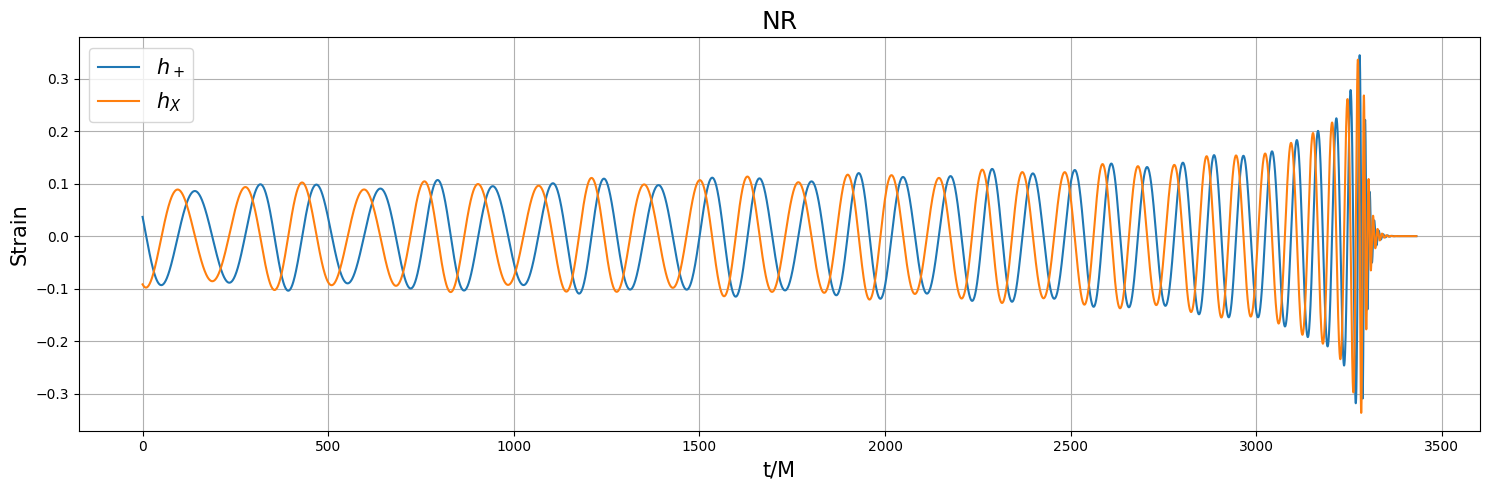

In [8]:
#NR
simulation = '/home/pratul/Downloads/rhOverM_Asymptotic_GeometricUnits_CoM.h5' #change simulations as needed
tref = 640.0 #check meta-data of NR simulations for tref
sims = simulation.split('_')[0]
lp = 2 #modes
mp = 2
mode = 'l'+str(lp)+'_m'+str(mp)
with h5py.File(simulation, 'r') as hdf:
    temp=hdf['OutermostExtraction.dir']['Y_'+mode+'.dat']
    test=np.array(temp)


#with h5py.File('1364_rhOverM_Asymptotic_GeometricUnits_CoM.h5', 'r') as hdf:
#    temp=hdf['OutermostExtraction.dir']['Y_l5_m5.dat']
#    test=np.array(temp)
        
x1=test[:,0]
y1=test[:,1]    
z1=test[:,2]

plotband=np.where(x1>=tref)
print(plotband)

x1=x1[plotband]
x1=x1-x1[0]
y1=y1[plotband]    
z1=z1[plotband]
print(len(x1))

tot=y1-1j*z1
amp=abs(tot)
ph=np.angle(tot)
phase_NR=np.unwrap(ph)
w=np.absolute(diff(phase_NR)/diff(x1))
phi0=phase_NR[0]

#setting t=0 at merger
#mergIdx_NR=np.argmax(amp)
#x1_peakatzero=x1-x1[mergIdx]

plt.figure(figsize=(15,5))
plt.plot(x1,y1,label='$h_+$')
plt.plot(x1,z1,label='$h_X$')
#plt.plot(x1,amp,'k--')
plt.title("NR",fontsize=18)
plt.ylabel("Strain", fontsize=15)
plt.xlabel("t/M", fontsize=15)
plt.grid()
plt.legend(loc=2,prop={'size': 15})
#plt.savefig('1364_20mode.pdf')

In [9]:
#parameters change with simulations
q=2
eref=0.05                                  
cl=lref=2.132
e0=0.125 #0.169 #0.12
eta=neu=nu=q/(1+q)**2 
xref=0.075   
xlow=0.045 #0.03365489193007444 
G=c=d=1
M = 1
M2=M/(1+q)
M1=M2*q
#modetopolfac=4*(5/(64*np.pi))**(1/2)  ## change according to mode

hl2m2pVec=y1
hl2m2cVec=z1

tVec=x1
hpVec=hl2m2pVec #* modetopolfac
hcVec= hl2m2cVec #* modetopolfac
M_SI=M*MSUN_SI
D_SI=(10**(6))*PC_SI
tVec_SI=tVec*M*MTSUN_SI
hpVec_SI=hpVec*G_SI*M_SI/D_SI/C_SI/C_SI
hcVec_SI=hcVec*G_SI*M_SI/D_SI/C_SI/C_SI

In [10]:
print(len(tVec_SI),len(hpVec_SI),len(hcVec_SI))

13578 13578 13578


9.5367431640625e-07
17721 17721


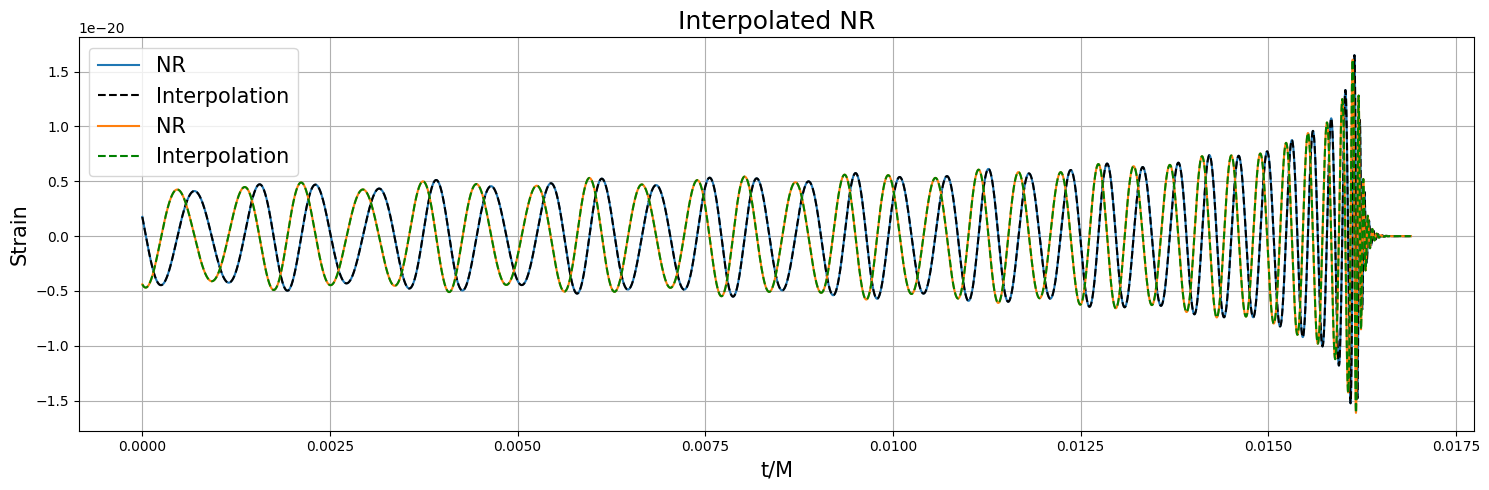

In [11]:
#delta_t_NR=np.max(abs(np.diff(tVec_SI)))   #max or min not the mean (t/M = 10, in secs it is 5*10**-5)

delta_t_NR = 1/2**20

print(delta_t_NR)

delta_t_common=delta_t_NR
t=tVec_SI
#### interpolation to sample data at equispaced time points
tVec_NR = np.linspace(t.min(),t.max(),int((t.max()-t.min())/delta_t_common)) 
hp_NR_sample = interp1d(t,hpVec_SI,kind='cubic')
hp_NR_int = hp_NR_sample(tVec_NR)
hc_NR_sample = interp1d(t,hcVec_SI,kind='cubic')
hc_NR_int = hc_NR_sample(tVec_NR)

#### converting to PyCBC TimeSeries
mergIdx_NR=np.argmax(np.abs(hp_NR_int+1j*hc_NR_int))
hpVec_NR = TimeSeries(hp_NR_int,delta_t_common,epoch=0)
hcVec_NR = TimeSeries(hc_NR_int,delta_t_common,epoch=0)

## phase and frequency
phase_NR=np.unwrap(np.angle(hpVec_NR + 1j*hcVec_NR)*2)/2
omega_NR = -(M*MTSUN_SI/delta_t_common)*(np.gradient(phase_NR))


plt.figure(figsize=(15,5))
plt.plot(tVec_SI,hpVec_SI,label='NR') 
plt.plot(tVec_NR,hp_NR_int,'k--',label='Interpolation')

plt.plot(tVec_SI,hcVec_SI,label='NR') 
plt.plot(tVec_NR,hc_NR_int,'g--',label='Interpolation')

plt.title("Interpolated NR",fontsize=18)
plt.ylabel("Strain", fontsize=15)
plt.xlabel("t/M", fontsize=15)
plt.grid()
plt.legend(loc=2,prop={'size': 15})
print(len(tVec_NR),len(hpVec_NR))

In [12]:
#PN

phiC=phase_NR[mergIdx_NR]                 
tC_NR=max(hpVec_NR.sample_times)
Delta=math.sqrt(1-(4*neu))
eta=nu=neu
gamma=EulerGamma= 0.577215664901

%run GW_functions.ipynb
mt=M                        #Total mass of eccentricTD wf 
m_sun=MSUN_SI                #Mass of sun in seconds
conv=mt*MTSUN_SI              #total mass (needed to convert PN time t to t/M)

#Formula to compute f from a given x
def freq(u,mass):
    return math.pow(u,3.0/2.0)/(2 * MTSUN_SI * mass * lal.PI / 2)   # f = x^(3/2) * c^3 / (G * M * 2pi/mp), mp = 2 for 22 mode
                                                                    # for 22 mode of EccTD, mp=2
f_low=freq(xlow,mt)            #Lower frequency of EccTD wf which is in our hands
f_ref=freq(xref,mt)            #Ref frequency of EccTD wf

####################################################

#Calculating ecc at xlow for generating EccTD wf-->eccentricity evolution Eq. (4.17a,b) Moore et. al.(2016)

%run GW_functions.ipynb         #Notebook with all PN evolution equations
x=xlow                         #x=point where eccentricity is required
v=math.sqrt(x)
vref=math.sqrt(xref)
xie=v**3
xiref=vref**3

#Gives e at xie with b.c.--> e=eref when xie=xiref

e=eref*(xiref/xie)**(19/18)*epsilon(xie, eta)/epsilon(xiref, eta)


In [13]:
print(e,e0)
print(f_low)  ## 22 mode frequency
print(f_ref)  ## 22 mode frequency
## PyCBC generates 22 mode only, so frequency for 22 mode required

0.12491576739528563 0.125
616.9065279526923
1327.3715049596763


In [14]:
hpVec_PN, hcVec_PN = get_td_waveform(approximant='EccentricTD', mass1=M1, mass2=M2, 
                         delta_t=delta_t_common, 
                         f_lower=f_low, 
                         eccentricity=e0,
                         distance=1)
print(hpVec_PN)
print(hcVec_PN)

[-1.48930805e-21 -1.49800694e-21 -1.50666776e-21 ... -6.62611186e-21
 -6.63715446e-21 -6.64393175e-21]
[1.75417576e-21 1.74675700e-21 1.73929379e-21 ... 3.70762348e-22
 2.02298382e-22 3.33621123e-23]


0.01689910888671875
[-0.07828426 -0.07828331 -0.07828236 ...  0.01689625  0.0168972
  0.01689816]
99807


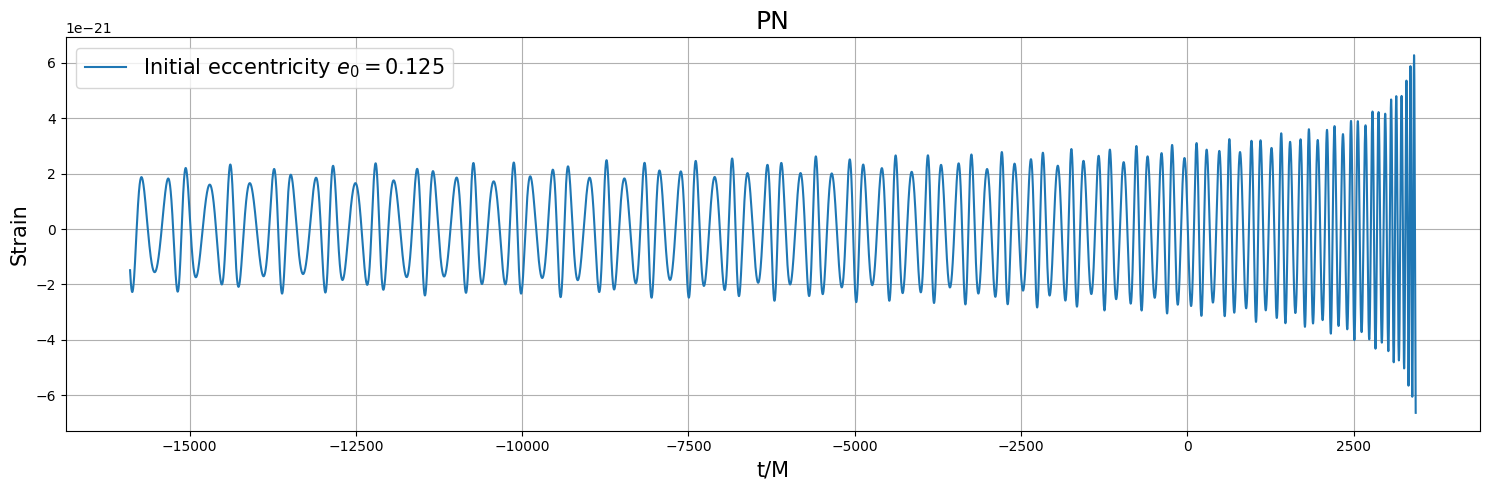

In [15]:
plt.figure(figsize=(15,5))
print(tC_NR)
tVec_PN_shifted=tC_NR+hpVec_PN.sample_times
print(tVec_PN_shifted)
plt.plot(tVec_PN_shifted/conv,hpVec_PN,label='Initial eccentricity $e_0=%1.3f$' %e)
plt.title("PN",fontsize=18)
plt.ylabel("Strain", fontsize=15)
plt.xlabel("t/M", fontsize=15)
plt.grid()
plt.legend(loc=2,prop={'size': 15})
print(len(hpVec_PN))

In [16]:
## eccentricTD from PyCBC is 22 mode, hence the modetopolfac value is for 22 mode
phase_EccTD = waveform.utils.phase_from_polarizations(hpVec_PN/((G_SI*M_SI/D_SI/C_SI/C_SI)), hcVec_PN/((G_SI*M_SI/D_SI/C_SI/C_SI)))
print(phase_EccTD)

[0.00000000e+00 4.96835508e-03 9.93671367e-03 ... 5.66297660e+02
 5.66323086e+02 5.66348535e+02]


In [17]:
## PyCBC generates only the 2,2 mode. So modetopolfac for 22 mode works for the PyCBC strain
tVec_PN_GM=tVec_PN_shifted/conv
tVec_NR_GM=tVec_NR/conv
hpVec_PN_GM=hpVec_PN/((G_SI*M_SI/D_SI/C_SI/C_SI))
hcVec_PN_GM=hcVec_PN/((G_SI*M_SI/D_SI/C_SI/C_SI))

In [18]:
tC_NR=tC_NR/conv
tC_NR

print(tVec_PN_GM)
print(hpVec_PN_GM)
print(hcVec_PN_GM)
print(tC_NR)

[-15893.69723898 -15893.50361882 -15893.30999867 ...   3430.36831733
   3430.56193748   3430.75555763]
[-0.03112181 -0.03130359 -0.03148457 ... -0.1384647  -0.13869546
 -0.13883708]
[0.0366567  0.03650168 0.03634572 ... 0.00774776 0.00422739 0.00069716]
3430.9490767681923


In [19]:
#%run GW_functions.ipynb 

#tVec_PN=hpVec_PN.sample_times/conv
tVec_PN=tVec_PN_GM
tC_NR=tC_NR

#print(tVec_PN)
#print(tC_NR)

xi_ref=xref**(3/2)
v_ref=xi_ref**(1/3)
#input initial params
x0=xlow
xi0=x0**(3/2)
v0=xi0**(1/3)
#e0=(eref*(xi_ref/xi0)**(19/18))*(epsilon(xi0, eta)/epsilon(xi_ref, eta))
l0=mean_anomaly(xi_ref, xi0, lref, eta,e0)
theta=((5*M/(eta))**(1/8))*(tC_NR-tVec_PN)**(-1/8)
theta0=((5*M/(eta))**(1/8))*(tC_NR-tVec_PN[0])**(-1/8)
fVec=x_from_t(theta, theta0, e0, M, eta)
#print(theta,theta0,e0,M,eta)
print(l0)

-11.257715012328479


In [20]:
print(theta,theta0)
#print(tVec_PN)
print(fVec)

[0.42979254 0.42979308 0.42979361 ... 1.57951328 1.66164945 1.81210069] 0.42979253744814117
[ 3.02624753e-03  3.02625902e-03  3.02627051e-03 ... -3.99184075e+00
 -6.60587837e+00 -1.56820100e+01]


In [21]:
####xiVec=(2*np.pi*M*fVec/mp)  ### probable relation for higher modes

xiVec=(np.pi*M*fVec)   ### might be for 22 mode only
#print('xiVec:', xiVec)
xVec=xiVec**(2/3)
print('xVec:', xVec)
vVec=xiVec**(1/3)
print(vVec)

xVec: [0.04487828 0.04487839 0.04487851 ...        nan        nan        nan]
[0.21184495 0.21184521 0.21184548 ...        nan        nan        nan]


/home/pratul/anaconda3/envs/pycbc/lib/python3.7/site-packages/pycbc/types/array.py:435: RuntimeWarning: invalid value encountered in power
  return self._data ** other


In [22]:
for i in range(0,len(xVec)):
    if xVec[i]>=0.1025:
        print(i)
        break
#lst = i
lst = 100105
#print(xVec[100100])
#print(xVec[lst])


98426


In [23]:
print(xiVec)

[ 9.50723702e-03  9.50727311e-03  9.50730920e-03 ... -1.25407376e+01
 -2.07529790e+01 -4.92664873e+01]


In [24]:
#selct +ve frequencies
plotIdx2=np.nonzero(fVec>=0)
fVec=fVec[plotIdx2]
xiVec=xiVec[plotIdx2]
xVec=xVec[plotIdx2]
vVec=vVec[plotIdx2]
maxPNidx=len(xVec)
print(plotIdx2,fVec,xiVec,xVec,vVec,maxPNidx)

(array([    0,     1,     2, ..., 99560, 99561, 99562]),) [3.02624753e-03 3.02625902e-03 3.02627051e-03 ... 2.23832757e-04
 1.45152297e-04 6.56818708e-05] [0.00950724 0.00950727 0.00950731 ... 0.00070319 0.00045601 0.00020635] [0.04487828 0.04487839 0.04487851 ... 0.00790768 0.00592447 0.00349191] [0.21184495 0.21184521 0.21184548 ... 0.08892513 0.07697055 0.05909242] 99563


In [25]:
len(xVec), len(phase_EccTD)

(99563, 99807)

In [26]:


j=0
omega=[]
phasePN = []
hlm_real=[]
hlm_imag=[]
hlm_abs22=[]
for i in tqdm(xVec):
    v=math.sqrt(i)
    v0=math.sqrt(x0)
    xie=v**3
    xi0=v0**3
    e=e0*(xi0/xie)**(19/18)*epsilon(xie, eta)/epsilon(xi0, eta)
    l=mean_anomaly(xie, xi0, l0, eta,e0) 
    
    psi=phase_EccTD[j]
    j=j+1
    xi=l   #use xi for amplitude (xie is being used for v**3)
    x=i
    h=amplitude_22(xi,x,nu,Delta,e) #### 22 mode requires additional  eccentricity input
    phasePN.append(mp*psi/2)
    hlm=8*math.sqrt(math.pi/5)*M*neu*i*h*((np.e)**(complex(0,-1)*mp*psi/2))/d
    hlm_real.append(hlm.real)
    hlm_imag.append(hlm.imag)
    hlm_abs22.append(abs(hlm))

100%|███████████████████████████████████| 99563/99563 [01:25<00:00, 1165.18it/s]


In [27]:
#print(hlm_abs44[:maxPNidx])

In [28]:
mp, j
NRamp = abs(hpVec_NR/(G_SI*M_SI/D_SI/C_SI/C_SI) + 1j*hcVec_NR/(G_SI*M_SI/D_SI/C_SI/C_SI))
hpPN = np.array(hlm_real)
hcPN = np.array(hlm_imag)
#phase_PN = np.unwrap(np.angle(hpPN - 1j*hcPN)*2)/2
phase_PN = phasePN
omega_PN = (M*MTSUN_SI/delta_t_common)*(np.gradient(phase_PN))
#print(type(hlm_imag))
NRamp22= NRamp
NRomega22= omega_NR
tNR22= tVec_NR_GM

PNamp22= hlm_abs22[:maxPNidx]
PNomega22= omega_PN[:maxPNidx]
tPN22= tVec_PN_GM[:maxPNidx]
print(len(omega_NR),len(tNR22))
#print(PNamp55[:lst])

17721 17721


# $(l,m)=(2,1)$

In [29]:
simulation = '/home/pratul/Downloads/rhOverM_Asymptotic_GeometricUnits_CoM.h5' #change simulations as needed
tref = 640.0 #check meta-data of NR simulations for tref
sims = simulation.split('_')[0]
lp = 2 #modes
mp = 1
mode = 'l'+str(lp)+'_m'+str(mp)
with h5py.File(simulation, 'r') as hdf:
    temp=hdf['OutermostExtraction.dir']['Y_'+mode+'.dat']
    test=np.array(temp)


#with h5py.File('1364_rhOverM_Asymptotic_GeometricUnits_CoM.h5', 'r') as hdf:
#    temp=hdf['OutermostExtraction.dir']['Y_l5_m5.dat']
#    test=np.array(temp)
        
x1=test[:,0]
y1=test[:,1]    
z1=test[:,2]

plotband=np.where(x1>=tref)
print(plotband)

x1=x1[plotband]
x1=x1-x1[0]
y1=y1[plotband]    
z1=z1[plotband]
print(len(x1))

tot=y1-1j*z1
amp=abs(tot)
ph=np.angle(tot)
phase_NR=np.unwrap(ph)
w=np.absolute(diff(phase_NR)/diff(x1))
phi0=phase_NR[0]

#setting t=0 at merger
#mergIdx_NR=np.argmax(amp)
#x1_peakatzero=x1-x1[mergIdx]

#plt.figure(figsize=(15,5))
#plt.plot(x1,y1,label='$h_+$')
#plt.plot(x1,z1,label='$h_X$')
#plt.plot(x1,amp,'k--')
#plt.title("NR",fontsize=18)
#plt.ylabel("Strain", fontsize=15)
#plt.xlabel("t/M", fontsize=15)
#plt.grid()
#plt.legend(loc=2,prop={'size': 15})
#plt.savefig('1364_20mode.pdf')

#parameters change with simulations
q=2
eref=0.05                                  
cl=lref=2.132
e0=0.169 #0.12
eta=neu=nu=q/(1+q)**2 
xref=0.075   
xlow=0.03365489193007444 #0.045
G=c=d=1
M = 1
M2=M/(1+q)
M1=M2*q
#modetopolfac=4*(5/(64*np.pi))**(1/2)  ## change according to mode

hl2m2pVec=y1
hl2m2cVec=z1

tVec=x1
hpVec=hl2m2pVec #* modetopolfac
hcVec= hl2m2cVec #* modetopolfac
M_SI=M*MSUN_SI
D_SI=(10**(6))*PC_SI
tVec_SI=tVec*M*MTSUN_SI
hpVec_SI=hpVec*G_SI*M_SI/D_SI/C_SI/C_SI
hcVec_SI=hcVec*G_SI*M_SI/D_SI/C_SI/C_SI

#delta_t_NR=np.max(abs(np.diff(tVec_SI)))   #max or min not the mean (t/M = 10, in secs it is 5*10**-5)

delta_t_NR = 1/2**20

#print(delta_t_NR)

delta_t_common=delta_t_NR
t=tVec_SI
#### interpolation to sample data at equispaced time points
tVec_NR = np.linspace(t.min(),t.max(),int((t.max()-t.min())/delta_t_common)) 
hp_NR_sample = interp1d(t,hpVec_SI,kind='cubic')
hp_NR_int = hp_NR_sample(tVec_NR)
hc_NR_sample = interp1d(t,hcVec_SI,kind='cubic')
hc_NR_int = hc_NR_sample(tVec_NR)

#### converting to PyCBC TimeSeries
mergIdx_NR=np.argmax(np.abs(hp_NR_int+1j*hc_NR_int))
hpVec_NR_21 = TimeSeries(hp_NR_int,delta_t_common,epoch=0)
hcVec_NR_21 = TimeSeries(hc_NR_int,delta_t_common,epoch=0)

## phase and frequency
phase_NR=np.unwrap(np.angle(hpVec_NR_21 + 1j*hcVec_NR_21)*2)/2
omega_NR = -(M*MTSUN_SI/delta_t_common)*(np.gradient(phase_NR))


#plt.figure(figsize=(15,5))
#plt.plot(tVec_SI,hpVec_SI,label='NR') 
#plt.plot(tVec_NR,hp_NR_int,'k--',label='Interpolation')

#plt.plot(tVec_SI,hcVec_SI,label='NR') 
#plt.plot(tVec_NR,hc_NR_int,'g--',label='Interpolation')

#plt.title("Interpolated NR",fontsize=18)
#plt.ylabel("Strain", fontsize=15)
#plt.xlabel("t/M", fontsize=15)
#plt.grid()
#plt.legend(loc=2,prop={'size': 15})
print(len(tVec_NR),len(hpVec_NR))




(array([  980,   981,   982, ..., 14555, 14556, 14557]),)
13578
17721 17721


In [30]:

j=0
omega=[]
phasePN = []
hlm_real=[]
hlm_imag=[]
hlm_abs21=[]
for i in tqdm(xVec):
    v=math.sqrt(i)
    v0=math.sqrt(x0)
    xie=v**3
    xi0=v0**3
    e=e0*(xi0/xie)**(19/18)*epsilon(xie, eta)/epsilon(xi0, eta)
    l=mean_anomaly(xie, xi0, l0, eta,e0) 
    
    psi=phase_EccTD[j]
    j=j+1
    xi=l   #use xi for amplitude (xie is being used for v**3)
    x=i
    h=amplitude_21(xi,x,nu,Delta,e) #### 22 mode requires additional  eccentricity input
    phasePN.append(mp*psi/2)
    hlm=8*math.sqrt(math.pi/5)*M*neu*i*h*((np.e)**(complex(0,-1)*mp*psi/2))/d
    hlm_real.append(hlm.real)
    hlm_imag.append(hlm.imag)
    hlm_abs21.append(abs(hlm))

100%|███████████████████████████████████| 99563/99563 [00:37<00:00, 2621.86it/s]


In [31]:
mp, j
NRamp = abs(hpVec_NR_21/(G_SI*M_SI/D_SI/C_SI/C_SI) + 1j*hcVec_NR_21/(G_SI*M_SI/D_SI/C_SI/C_SI))
hpPN = np.array(hlm_real)
hcPN = np.array(hlm_imag)
#phase_PN = np.unwrap(np.angle(hpPN - 1j*hcPN)*2)/2
phase_PN = phasePN
omega_PN = (M*MTSUN_SI/delta_t_common)*(np.gradient(phase_PN))
#print(type(hlm_imag))
NRamp21= NRamp
NRomega21= omega_NR
tNR21= tVec_NR_GM

PNamp21= hlm_abs21[:maxPNidx]
PNomega21= omega_PN[:maxPNidx]
tPN21= tVec_PN_GM[:maxPNidx]
#print(PNamp55[:lst])
print(len(omega_NR),len(tVec_NR))

17721 17721


# $(l,m)=(3,3)$

In [32]:
simulation = '/home/pratul/Downloads/rhOverM_Asymptotic_GeometricUnits_CoM.h5' #change simulations as needed
tref = 640.0 #check meta-data of NR simulations for tref
sims = simulation.split('_')[0]
lp = 3 #modes
mp = 3
mode = 'l'+str(lp)+'_m'+str(mp)
with h5py.File(simulation, 'r') as hdf:
    temp=hdf['OutermostExtraction.dir']['Y_'+mode+'.dat']
    test=np.array(temp)


#with h5py.File('1364_rhOverM_Asymptotic_GeometricUnits_CoM.h5', 'r') as hdf:
#    temp=hdf['OutermostExtraction.dir']['Y_l5_m5.dat']
#    test=np.array(temp)
        
x1=test[:,0]
y1=test[:,1]    
z1=test[:,2]

plotband=np.where(x1>=tref)
print(plotband)

x1=x1[plotband]
x1=x1-x1[0]
y1=y1[plotband]    
z1=z1[plotband]
print(len(x1))

tot=y1-1j*z1
amp=abs(tot)
ph=np.angle(tot)
phase_NR=np.unwrap(ph)
w=np.absolute(diff(phase_NR)/diff(x1))
phi0=phase_NR[0]

#setting t=0 at merger
#mergIdx_NR=np.argmax(amp)
#x1_peakatzero=x1-x1[mergIdx]

#plt.figure(figsize=(15,5))
#plt.plot(x1,y1,label='$h_+$')
#plt.plot(x1,z1,label='$h_X$')
#plt.plot(x1,amp,'k--')
#plt.title("NR",fontsize=18)
#plt.ylabel("Strain", fontsize=15)
#plt.xlabel("t/M", fontsize=15)
#plt.grid()
#plt.legend(loc=2,prop={'size': 15})
#plt.savefig('1364_20mode.pdf')

#parameters change with simulations
q=2
eref=0.05                                  
cl=lref=2.132
e0=0.169 #0.12
eta=neu=nu=q/(1+q)**2 
xref=0.075   
xlow=0.03365489193007444 #0.045
G=c=d=1
M = 1
M2=M/(1+q)
M1=M2*q
#modetopolfac=4*(5/(64*np.pi))**(1/2)  ## change according to mode

hl2m2pVec=y1
hl2m2cVec=z1

tVec=x1
hpVec=hl2m2pVec #* modetopolfac
hcVec= hl2m2cVec #* modetopolfac
M_SI=M*MSUN_SI
D_SI=(10**(6))*PC_SI
tVec_SI=tVec*M*MTSUN_SI
hpVec_SI=hpVec*G_SI*M_SI/D_SI/C_SI/C_SI
hcVec_SI=hcVec*G_SI*M_SI/D_SI/C_SI/C_SI

#delta_t_NR=np.max(abs(np.diff(tVec_SI)))   #max or min not the mean (t/M = 10, in secs it is 5*10**-5)

delta_t_NR = 1/2**20

#print(delta_t_NR)

delta_t_common=delta_t_NR
t=tVec_SI
#### interpolation to sample data at equispaced time points
tVec_NR = np.linspace(t.min(),t.max(),int((t.max()-t.min())/delta_t_common)) 
hp_NR_sample = interp1d(t,hpVec_SI,kind='cubic')
hp_NR_int = hp_NR_sample(tVec_NR)
hc_NR_sample = interp1d(t,hcVec_SI,kind='cubic')
hc_NR_int = hc_NR_sample(tVec_NR)

#### converting to PyCBC TimeSeries
mergIdx_NR=np.argmax(np.abs(hp_NR_int+1j*hc_NR_int))
hpVec_NR_33 = TimeSeries(hp_NR_int,delta_t_common,epoch=0)
hcVec_NR_33 = TimeSeries(hc_NR_int,delta_t_common,epoch=0)

## phase and frequency
phase_NR=np.unwrap(np.angle(hpVec_NR_33 + 1j*hcVec_NR_33)*2)/2
omega_NR = -(M*MTSUN_SI/delta_t_common)*(np.gradient(phase_NR))


#plt.figure(figsize=(15,5))
#plt.plot(tVec_SI,hpVec_SI,label='NR') 
#plt.plot(tVec_NR,hp_NR_int,'k--',label='Interpolation')

#plt.plot(tVec_SI,hcVec_SI,label='NR') 
#plt.plot(tVec_NR,hc_NR_int,'g--',label='Interpolation')

#plt.title("Interpolated NR",fontsize=18)
#plt.ylabel("Strain", fontsize=15)
#plt.xlabel("t/M", fontsize=15)
#plt.grid()
#plt.legend(loc=2,prop={'size': 15})
#print(len(t),len(hpVec_NR))



(array([  980,   981,   982, ..., 14555, 14556, 14557]),)
13578


In [33]:
j=0
omega=[]
phasePN = []
hlm_real=[]
hlm_imag=[]
hlm_abs33=[]
for i in tqdm(xVec):
    v=math.sqrt(i)
    v0=math.sqrt(x0)
    xie=v**3
    xi0=v0**3
    e=e0*(xi0/xie)**(19/18)*epsilon(xie, eta)/epsilon(xi0, eta)
    l=mean_anomaly(xie, xi0, l0, eta,e0) 
    
    psi=phase_EccTD[j]
    j=j+1
    xi=l   #use xi for amplitude (xie is being used for v**3)
    x=i
    h=amplitude_33(xi,x,nu,Delta,e) #### 22 mode requires additional  eccentricity input
    phasePN.append(mp*psi/2)
    hlm=8*math.sqrt(math.pi/5)*M*neu*i*h*((np.e)**(complex(0,-1)*mp*psi/2))/d
    hlm_real.append(hlm.real)
    hlm_imag.append(hlm.imag)
    hlm_abs33.append(abs(hlm))

100%|███████████████████████████████████| 99563/99563 [00:43<00:00, 2264.78it/s]


In [34]:
mp, j
NRamp = abs(hpVec_NR_33/(G_SI*M_SI/D_SI/C_SI/C_SI) + 1j*hcVec_NR_33/(G_SI*M_SI/D_SI/C_SI/C_SI))
hpPN = np.array(hlm_real)
hcPN = np.array(hlm_imag)
#phase_PN = np.unwrap(np.angle(hpPN - 1j*hcPN)*2)/2
phase_PN = phasePN
omega_PN = (M*MTSUN_SI/delta_t_common)*(np.gradient(phase_PN))
#print(type(hlm_imag))
NRamp33= NRamp
NRomega33= omega_NR
tNR33= tVec_NR_GM

PNamp33= hlm_abs33[:maxPNidx]
PNomega33= omega_PN[:maxPNidx]
tPN33= tVec_PN_GM[:maxPNidx]
#print(PNamp55[:lst])

# $(l,m)=(3,2)$

In [35]:
simulation = '/home/pratul/Downloads/rhOverM_Asymptotic_GeometricUnits_CoM.h5' #change simulations as needed
tref = 640.0 #check meta-data of NR simulations for tref
sims = simulation.split('_')[0]
lp = 3 #modes
mp = 2
mode = 'l'+str(lp)+'_m'+str(mp)
with h5py.File(simulation, 'r') as hdf:
    temp=hdf['OutermostExtraction.dir']['Y_'+mode+'.dat']
    test=np.array(temp)


#with h5py.File('1364_rhOverM_Asymptotic_GeometricUnits_CoM.h5', 'r') as hdf:
#    temp=hdf['OutermostExtraction.dir']['Y_l5_m5.dat']
#    test=np.array(temp)
        
x1=test[:,0]
y1=test[:,1]    
z1=test[:,2]

plotband=np.where(x1>=tref)
print(plotband)

x1=x1[plotband]
x1=x1-x1[0]
y1=y1[plotband]    
z1=z1[plotband]
print(len(x1))

tot=y1-1j*z1
amp=abs(tot)
ph=np.angle(tot)
phase_NR=np.unwrap(ph)
w=np.absolute(diff(phase_NR)/diff(x1))
phi0=phase_NR[0]

#setting t=0 at merger
#mergIdx_NR=np.argmax(amp)
#x1_peakatzero=x1-x1[mergIdx]

#plt.figure(figsize=(15,5))
#plt.plot(x1,y1,label='$h_+$')
#plt.plot(x1,z1,label='$h_X$')
#plt.plot(x1,amp,'k--')
#plt.title("NR",fontsize=18)
#plt.ylabel("Strain", fontsize=15)
#plt.xlabel("t/M", fontsize=15)
#plt.grid()
#plt.legend(loc=2,prop={'size': 15})
#plt.savefig('1364_20mode.pdf')

#parameters change with simulations
q=2
eref=0.05                                  
cl=lref=2.132
e0=0.169 #0.12
eta=neu=nu=q/(1+q)**2 
xref=0.075   
xlow=0.03365489193007444 #0.045
G=c=d=1
M = 1
M2=M/(1+q)
M1=M2*q
#modetopolfac=4*(5/(64*np.pi))**(1/2)  ## change according to mode

hl2m2pVec=y1
hl2m2cVec=z1

tVec=x1
hpVec=hl2m2pVec #* modetopolfac
hcVec= hl2m2cVec #* modetopolfac
M_SI=M*MSUN_SI
D_SI=(10**(6))*PC_SI
tVec_SI=tVec*M*MTSUN_SI
hpVec_SI=hpVec*G_SI*M_SI/D_SI/C_SI/C_SI
hcVec_SI=hcVec*G_SI*M_SI/D_SI/C_SI/C_SI

#delta_t_NR=np.max(abs(np.diff(tVec_SI)))   #max or min not the mean (t/M = 10, in secs it is 5*10**-5)

delta_t_NR = 1/2**20

#print(delta_t_NR)

delta_t_common=delta_t_NR
t=tVec_SI
#### interpolation to sample data at equispaced time points
tVec_NR = np.linspace(t.min(),t.max(),int((t.max()-t.min())/delta_t_common)) 
hp_NR_sample = interp1d(t,hpVec_SI,kind='cubic')
hp_NR_int = hp_NR_sample(tVec_NR)
hc_NR_sample = interp1d(t,hcVec_SI,kind='cubic')
hc_NR_int = hc_NR_sample(tVec_NR)

#### converting to PyCBC TimeSeries
mergIdx_NR=np.argmax(np.abs(hp_NR_int+1j*hc_NR_int))
hpVec_NR_32 = TimeSeries(hp_NR_int,delta_t_common,epoch=0)
hcVec_NR_32 = TimeSeries(hc_NR_int,delta_t_common,epoch=0)

## phase and frequency
phase_NR=np.unwrap(np.angle(hpVec_NR_32 + 1j*hcVec_NR_32)*2)/2
omega_NR = -(M*MTSUN_SI/delta_t_common)*(np.gradient(phase_NR))


#plt.figure(figsize=(15,5))
#plt.plot(tVec_SI,hpVec_SI,label='NR') 
#plt.plot(tVec_NR,hp_NR_int,'k--',label='Interpolation')

#plt.plot(tVec_SI,hcVec_SI,label='NR') 
#plt.plot(tVec_NR,hc_NR_int,'g--',label='Interpolation')

#plt.title("Interpolated NR",fontsize=18)
#plt.ylabel("Strain", fontsize=15)
#plt.xlabel("t/M", fontsize=15)
#plt.grid()
#plt.legend(loc=2,prop={'size': 15})
#print(len(t),len(hpVec_NR))

(array([  980,   981,   982, ..., 14555, 14556, 14557]),)
13578


In [36]:
j=0
omega=[]
phasePN = []
hlm_real=[]
hlm_imag=[]
hlm_abs32=[]
for i in tqdm(xVec):
    v=math.sqrt(i)
    v0=math.sqrt(x0)
    xie=v**3
    xi0=v0**3
    e=e0*(xi0/xie)**(19/18)*epsilon(xie, eta)/epsilon(xi0, eta)
    l=mean_anomaly(xie, xi0, l0, eta,e0) 
    
    psi=phase_EccTD[j]
    j=j+1
    xi=l   #use xi for amplitude (xie is being used for v**3)
    x=i
    h=amplitude_32(xi,x,nu,Delta,e) #### 22 mode requires additional  eccentricity input
    phasePN.append(mp*psi/2)
    hlm=8*math.sqrt(math.pi/5)*M*neu*i*h*((np.e)**(complex(0,-1)*mp*psi/2))/d
    hlm_real.append(hlm.real)
    hlm_imag.append(hlm.imag)
    hlm_abs32.append(abs(hlm))

100%|███████████████████████████████████| 99563/99563 [00:26<00:00, 3793.08it/s]


In [37]:
mp, j
NRamp = abs(hpVec_NR_32/(G_SI*M_SI/D_SI/C_SI/C_SI) + 1j*hcVec_NR_32/(G_SI*M_SI/D_SI/C_SI/C_SI))
hpPN = np.array(hlm_real)
hcPN = np.array(hlm_imag)
#phase_PN = np.unwrap(np.angle(hpPN - 1j*hcPN)*2)/2
phase_PN = phasePN
omega_PN = (M*MTSUN_SI/delta_t_common)*(np.gradient(phase_PN))
#print(type(hlm_imag))
NRamp32= NRamp
NRomega32= omega_NR
tNR32= tVec_NR_GM

PNamp32= hlm_abs32[:maxPNidx]
PNomega32= omega_PN[:maxPNidx]
tPN32= tVec_PN_GM[:maxPNidx]
#print(PNamp55[:lst])

# $(l,m)=(4,4)$

In [38]:
simulation = '/home/pratul/Downloads/rhOverM_Asymptotic_GeometricUnits_CoM.h5' #change simulations as needed
tref = 640.0 #check meta-data of NR simulations for tref
sims = simulation.split('_')[0]
lp = 4 #modes
mp = 4
mode = 'l'+str(lp)+'_m'+str(mp)
with h5py.File(simulation, 'r') as hdf:
    temp=hdf['OutermostExtraction.dir']['Y_'+mode+'.dat']
    test=np.array(temp)


#with h5py.File('1364_rhOverM_Asymptotic_GeometricUnits_CoM.h5', 'r') as hdf:
#    temp=hdf['OutermostExtraction.dir']['Y_l5_m5.dat']
#    test=np.array(temp)
        
x1=test[:,0]
y1=test[:,1]    
z1=test[:,2]

plotband=np.where(x1>=tref)
print(plotband)

x1=x1[plotband]
x1=x1-x1[0]
y1=y1[plotband]    
z1=z1[plotband]
print(len(x1))

tot=y1-1j*z1
amp=abs(tot)
ph=np.angle(tot)
phase_NR=np.unwrap(ph)
w=np.absolute(diff(phase_NR)/diff(x1))
phi0=phase_NR[0]

#setting t=0 at merger
#mergIdx_NR=np.argmax(amp)
#x1_peakatzero=x1-x1[mergIdx]

#plt.figure(figsize=(15,5))
#plt.plot(x1,y1,label='$h_+$')
#plt.plot(x1,z1,label='$h_X$')
#plt.plot(x1,amp,'k--')
#plt.title("NR",fontsize=18)
#plt.ylabel("Strain", fontsize=15)
#plt.xlabel("t/M", fontsize=15)
#plt.grid()
#plt.legend(loc=2,prop={'size': 15})
#plt.savefig('1364_20mode.pdf')

#parameters change with simulations
q=2
eref=0.05                                  
cl=lref=2.132
e0=0.169 #0.12
eta=neu=nu=q/(1+q)**2 
xref=0.075   
xlow=0.03365489193007444 #0.045
G=c=d=1
M = 1
M2=M/(1+q)
M1=M2*q
#modetopolfac=4*(5/(64*np.pi))**(1/2)  ## change according to mode

hl2m2pVec=y1
hl2m2cVec=z1

tVec=x1
hpVec=hl2m2pVec #* modetopolfac
hcVec= hl2m2cVec #* modetopolfac
M_SI=M*MSUN_SI
D_SI=(10**(6))*PC_SI
tVec_SI=tVec*M*MTSUN_SI
hpVec_SI=hpVec*G_SI*M_SI/D_SI/C_SI/C_SI
hcVec_SI=hcVec*G_SI*M_SI/D_SI/C_SI/C_SI

#delta_t_NR=np.max(abs(np.diff(tVec_SI)))   #max or min not the mean (t/M = 10, in secs it is 5*10**-5)

delta_t_NR = 1/2**20

#print(delta_t_NR)

delta_t_common=delta_t_NR
t=tVec_SI
#### interpolation to sample data at equispaced time points
tVec_NR = np.linspace(t.min(),t.max(),int((t.max()-t.min())/delta_t_common)) 
hp_NR_sample = interp1d(t,hpVec_SI,kind='cubic')
hp_NR_int = hp_NR_sample(tVec_NR)
hc_NR_sample = interp1d(t,hcVec_SI,kind='cubic')
hc_NR_int = hc_NR_sample(tVec_NR)

#### converting to PyCBC TimeSeries
mergIdx_NR=np.argmax(np.abs(hp_NR_int+1j*hc_NR_int))
hpVec_NR_44 = TimeSeries(hp_NR_int,delta_t_common,epoch=0)
hcVec_NR_44 = TimeSeries(hc_NR_int,delta_t_common,epoch=0)

## phase and frequency
phase_NR=np.unwrap(np.angle(hpVec_NR_44 + 1j*hcVec_NR_44)*2)/2
omega_NR = -(M*MTSUN_SI/delta_t_common)*(np.gradient(phase_NR))


#plt.figure(figsize=(15,5))
#plt.plot(tVec_SI,hpVec_SI,label='NR') 
#plt.plot(tVec_NR,hp_NR_int,'k--',label='Interpolation')

#plt.plot(tVec_SI,hcVec_SI,label='NR') 
#plt.plot(tVec_NR,hc_NR_int,'g--',label='Interpolation')

#plt.title("Interpolated NR",fontsize=18)
#plt.ylabel("Strain", fontsize=15)
#plt.xlabel("t/M", fontsize=15)
#plt.grid()
#plt.legend(loc=2,prop={'size': 15})
#print(len(t),len(hpVec_NR))

(array([  980,   981,   982, ..., 14555, 14556, 14557]),)
13578


In [39]:
j=0
omega=[]
phasePN = []
hlm_real=[]
hlm_imag=[]
hlm_abs44=[]
for i in tqdm(xVec):
    v=math.sqrt(i)
    v0=math.sqrt(x0)
    xie=v**3
    xi0=v0**3
    e=e0*(xi0/xie)**(19/18)*epsilon(xie, eta)/epsilon(xi0, eta)
    l=mean_anomaly(xie, xi0, l0, eta,e0) 
    
    psi=phase_EccTD[j]
    j=j+1
    xi=l   #use xi for amplitude (xie is being used for v**3)
    x=i
    h=amplitude_44(xi,x,nu,Delta,e) #### 22 mode requires additional  eccentricity input
    phasePN.append(mp*psi/2)
    hlm=8*math.sqrt(math.pi/5)*M*neu*i*h*((np.e)**(complex(0,-1)*mp*psi/2))/d
    hlm_real.append(hlm.real)
    hlm_imag.append(hlm.imag)
    hlm_abs44.append(abs(hlm))

100%|███████████████████████████████████| 99563/99563 [00:32<00:00, 3107.90it/s]


In [40]:
mp, j
NRamp = abs(hpVec_NR_44/(G_SI*M_SI/D_SI/C_SI/C_SI) + 1j*hcVec_NR_44/(G_SI*M_SI/D_SI/C_SI/C_SI))
hpPN = np.array(hlm_real)
hcPN = np.array(hlm_imag)
#phase_PN = np.unwrap(np.angle(hpPN - 1j*hcPN)*2)/2
phase_PN = phasePN
omega_PN = (M*MTSUN_SI/delta_t_common)*(np.gradient(phase_PN))
#print(type(hlm_imag))
NRamp44= NRamp
NRomega44= omega_NR
tNR44= tVec_NR_GM

PNamp44= hlm_abs44[:maxPNidx]
PNomega44= omega_PN[:maxPNidx]
tPN44= tVec_PN_GM[:maxPNidx]
#print(PNamp55[:lst])

# $(l,m)=(5,5)$

In [41]:
simulation = '/home/pratul/Downloads/rhOverM_Asymptotic_GeometricUnits_CoM.h5' #change simulations as needed
tref = 640.0 #check meta-data of NR simulations for tref
sims = simulation.split('_')[0]
lp = 4 #modes
mp = 3
mode = 'l'+str(lp)+'_m'+str(mp)
with h5py.File(simulation, 'r') as hdf:
    temp=hdf['OutermostExtraction.dir']['Y_'+mode+'.dat']
    test=np.array(temp)


#with h5py.File('1364_rhOverM_Asymptotic_GeometricUnits_CoM.h5', 'r') as hdf:
#    temp=hdf['OutermostExtraction.dir']['Y_l5_m5.dat']
#    test=np.array(temp)
        
x1=test[:,0]
y1=test[:,1]    
z1=test[:,2]

plotband=np.where(x1>=tref)
print(plotband)

x1=x1[plotband]
x1=x1-x1[0]
y1=y1[plotband]    
z1=z1[plotband]
print(len(x1))

tot=y1-1j*z1
amp=abs(tot)
ph=np.angle(tot)
phase_NR=np.unwrap(ph)
w=np.absolute(diff(phase_NR)/diff(x1))
phi0=phase_NR[0]

#setting t=0 at merger
#mergIdx_NR=np.argmax(amp)
#x1_peakatzero=x1-x1[mergIdx]

#plt.figure(figsize=(15,5))
#plt.plot(x1,y1,label='$h_+$')
#plt.plot(x1,z1,label='$h_X$')
#plt.plot(x1,amp,'k--')
#plt.title("NR",fontsize=18)
#plt.ylabel("Strain", fontsize=15)
#plt.xlabel("t/M", fontsize=15)
#plt.grid()
#plt.legend(loc=2,prop={'size': 15})
#plt.savefig('1364_20mode.pdf')

#parameters change with simulations
q=2
eref=0.05                                  
cl=lref=2.132
e0=0.169 #0.12
eta=neu=nu=q/(1+q)**2 
xref=0.075   
xlow=0.03365489193007444 #0.045
G=c=d=1
M = 1
M2=M/(1+q)
M1=M2*q
#modetopolfac=4*(5/(64*np.pi))**(1/2)  ## change according to mode

hl2m2pVec=y1
hl2m2cVec=z1

tVec=x1
hpVec=hl2m2pVec #* modetopolfac
hcVec= hl2m2cVec #* modetopolfac
M_SI=M*MSUN_SI
D_SI=(10**(6))*PC_SI
tVec_SI=tVec*M*MTSUN_SI
hpVec_SI=hpVec*G_SI*M_SI/D_SI/C_SI/C_SI
hcVec_SI=hcVec*G_SI*M_SI/D_SI/C_SI/C_SI

#delta_t_NR=np.max(abs(np.diff(tVec_SI)))   #max or min not the mean (t/M = 10, in secs it is 5*10**-5)

delta_t_NR = 1/2**20

#print(delta_t_NR)

delta_t_common=delta_t_NR
t=tVec_SI
#### interpolation to sample data at equispaced time points
tVec_NR = np.linspace(t.min(),t.max(),int((t.max()-t.min())/delta_t_common)) 
hp_NR_sample = interp1d(t,hpVec_SI,kind='cubic')
hp_NR_int = hp_NR_sample(tVec_NR)
hc_NR_sample = interp1d(t,hcVec_SI,kind='cubic')
hc_NR_int = hc_NR_sample(tVec_NR)

#### converting to PyCBC TimeSeries
mergIdx_NR=np.argmax(np.abs(hp_NR_int+1j*hc_NR_int))
hpVec_NR_43 = TimeSeries(hp_NR_int,delta_t_common,epoch=0)
hcVec_NR_43 = TimeSeries(hc_NR_int,delta_t_common,epoch=0)

## phase and frequency
phase_NR=np.unwrap(np.angle(hpVec_NR_43 + 1j*hcVec_NR_43)*2)/2
omega_NR = -(M*MTSUN_SI/delta_t_common)*(np.gradient(phase_NR))


#plt.figure(figsize=(15,5))
#plt.plot(tVec_SI,hpVec_SI,label='NR') 
#plt.plot(tVec_NR,hp_NR_int,'k--',label='Interpolation')

#plt.plot(tVec_SI,hcVec_SI,label='NR') 
#plt.plot(tVec_NR,hc_NR_int,'g--',label='Interpolation')

#plt.title("Interpolated NR",fontsize=18)
#plt.ylabel("Strain", fontsize=15)
#plt.xlabel("t/M", fontsize=15)
#plt.grid()
#plt.legend(loc=2,prop={'size': 15})
#print(len(t),len(hpVec_NR))

(array([  980,   981,   982, ..., 14555, 14556, 14557]),)
13578


In [42]:
j=0
omega=[]
phasePN = []
hlm_real=[]
hlm_imag=[]
hlm_abs43=[]
for i in tqdm(xVec):
    v=math.sqrt(i)
    v0=math.sqrt(x0)
    xie=v**3
    xi0=v0**3
    e=e0*(xi0/xie)**(19/18)*epsilon(xie, eta)/epsilon(xi0, eta)
    l=mean_anomaly(xie, xi0, l0, eta,e0) 
    
    psi=phase_EccTD[j]
    j=j+1
    xi=l   #use xi for amplitude (xie is being used for v**3)
    x=i
    h=amplitude_43(xi,x,nu,Delta,e) #### 22 mode requires additional  eccentricity input
    phasePN.append(mp*psi/2)
    hlm=8*math.sqrt(math.pi/5)*M*neu*i*h*((np.e)**(complex(0,-1)*mp*psi/2))/d
    hlm_real.append(hlm.real)
    hlm_imag.append(hlm.imag)
    hlm_abs43.append(abs(hlm))

100%|███████████████████████████████████| 99563/99563 [00:30<00:00, 3275.73it/s]


In [43]:
mp, j
NRamp = abs(hpVec_NR_43/(G_SI*M_SI/D_SI/C_SI/C_SI) + 1j*hcVec_NR_43/(G_SI*M_SI/D_SI/C_SI/C_SI))
hpPN = np.array(hlm_real)
hcPN = np.array(hlm_imag)
#phase_PN = np.unwrap(np.angle(hpPN - 1j*hcPN)*2)/2
phase_PN = phasePN
omega_PN = (M*MTSUN_SI/delta_t_common)*(np.gradient(phase_PN))
#print(type(hlm_imag))
NRamp43= NRamp
NRomega43= omega_NR
tNR43= tVec_NR_GM

PNamp43= hlm_abs43[:maxPNidx]
PNomega43= omega_PN[:maxPNidx]
tPN43= tVec_PN_GM[:maxPNidx]
#print(PNamp55[:lst])

# $(l,m)=(5,5)$

In [44]:
simulation = '/home/pratul/Downloads/rhOverM_Asymptotic_GeometricUnits_CoM.h5' #change simulations as needed
tref = 640.0 #check meta-data of NR simulations for tref
sims = simulation.split('_')[0]
lp = 5 #modes
mp = 5
mode = 'l'+str(lp)+'_m'+str(mp)
with h5py.File(simulation, 'r') as hdf:
    temp=hdf['OutermostExtraction.dir']['Y_'+mode+'.dat']
    test=np.array(temp)


#with h5py.File('1364_rhOverM_Asymptotic_GeometricUnits_CoM.h5', 'r') as hdf:
#    temp=hdf['OutermostExtraction.dir']['Y_l5_m5.dat']
#    test=np.array(temp)
        
x1=test[:,0]
y1=test[:,1]    
z1=test[:,2]

plotband=np.where(x1>=tref)
print(plotband)

x1=x1[plotband]
x1=x1-x1[0]
y1=y1[plotband]    
z1=z1[plotband]
print(len(x1))

tot=y1-1j*z1
amp=abs(tot)
ph=np.angle(tot)
phase_NR=np.unwrap(ph)
w=np.absolute(diff(phase_NR)/diff(x1))
phi0=phase_NR[0]

#setting t=0 at merger
#mergIdx_NR=np.argmax(amp)
#x1_peakatzero=x1-x1[mergIdx]

#plt.figure(figsize=(15,5))
#plt.plot(x1,y1,label='$h_+$')
#plt.plot(x1,z1,label='$h_X$')
#plt.plot(x1,amp,'k--')
#plt.title("NR",fontsize=18)
#plt.ylabel("Strain", fontsize=15)
#plt.xlabel("t/M", fontsize=15)
#plt.grid()
#plt.legend(loc=2,prop={'size': 15})
#plt.savefig('1364_20mode.pdf')

#parameters change with simulations
q=2
eref=0.05                                  
cl=lref=2.132
e0=0.169 #0.12
eta=neu=nu=q/(1+q)**2 
xref=0.075   
xlow=0.03365489193007444 #0.045
G=c=d=1
M = 1
M2=M/(1+q)
M1=M2*q
#modetopolfac=4*(5/(64*np.pi))**(1/2)  ## change according to mode

hl2m2pVec=y1
hl2m2cVec=z1

tVec=x1
hpVec=hl2m2pVec #* modetopolfac
hcVec= hl2m2cVec #* modetopolfac
M_SI=M*MSUN_SI
D_SI=(10**(6))*PC_SI
tVec_SI=tVec*M*MTSUN_SI
hpVec_SI=hpVec*G_SI*M_SI/D_SI/C_SI/C_SI
hcVec_SI=hcVec*G_SI*M_SI/D_SI/C_SI/C_SI

#delta_t_NR=np.max(abs(np.diff(tVec_SI)))   #max or min not the mean (t/M = 10, in secs it is 5*10**-5)

delta_t_NR = 1/2**20

#print(delta_t_NR)

delta_t_common=delta_t_NR
t=tVec_SI
#### interpolation to sample data at equispaced time points
tVec_NR = np.linspace(t.min(),t.max(),int((t.max()-t.min())/delta_t_common)) 
hp_NR_sample = interp1d(t,hpVec_SI,kind='cubic')
hp_NR_int = hp_NR_sample(tVec_NR)
hc_NR_sample = interp1d(t,hcVec_SI,kind='cubic')
hc_NR_int = hc_NR_sample(tVec_NR)

#### converting to PyCBC TimeSeries
mergIdx_NR=np.argmax(np.abs(hp_NR_int+1j*hc_NR_int))
hpVec_NR_55 = TimeSeries(hp_NR_int,delta_t_common,epoch=0)
hcVec_NR_55 = TimeSeries(hc_NR_int,delta_t_common,epoch=0)

## phase and frequency
phase_NR=np.unwrap(np.angle(hpVec_NR_55 + 1j*hcVec_NR_55)*2)/2
omega_NR = -(M*MTSUN_SI/delta_t_common)*(np.gradient(phase_NR))


#plt.figure(figsize=(15,5))
#plt.plot(tVec_SI,hpVec_SI,label='NR') 
#plt.plot(tVec_NR,hp_NR_int,'k--',label='Interpolation')

#plt.plot(tVec_SI,hcVec_SI,label='NR') 
#plt.plot(tVec_NR,hc_NR_int,'g--',label='Interpolation')

#plt.title("Interpolated NR",fontsize=18)
#plt.ylabel("Strain", fontsize=15)
#plt.xlabel("t/M", fontsize=15)
#plt.grid()
#plt.legend(loc=2,prop={'size': 15})
#print(len(t),len(hpVec_NR))

(array([  980,   981,   982, ..., 14555, 14556, 14557]),)
13578


In [45]:
j=0
omega=[]
phasePN = []
hlm_real=[]
hlm_imag=[]
hlm_abs55=[]
for i in tqdm(xVec):
    v=math.sqrt(i)
    v0=math.sqrt(x0)
    xie=v**3
    xi0=v0**3
    e=e0*(xi0/xie)**(19/18)*epsilon(xie, eta)/epsilon(xi0, eta)
    l=mean_anomaly(xie, xi0, l0, eta,e0) 
    
    psi=phase_EccTD[j]
    j=j+1
    xi=l   #use xi for amplitude (xie is being used for v**3)
    x=i
    h=amplitude_55(xi,x,nu,Delta,e) #### 22 mode requires additional  eccentricity input
    phasePN.append(mp*psi/2)
    hlm=8*math.sqrt(math.pi/5)*M*neu*i*h*((np.e)**(complex(0,-1)*mp*psi/2))/d
    hlm_real.append(hlm.real)
    hlm_imag.append(hlm.imag)
    hlm_abs55.append(abs(hlm))

100%|███████████████████████████████████| 99563/99563 [00:37<00:00, 2647.88it/s]


In [46]:
mp, j
NRamp = abs(hpVec_NR_55/(G_SI*M_SI/D_SI/C_SI/C_SI) + 1j*hcVec_NR_55/(G_SI*M_SI/D_SI/C_SI/C_SI))
hpPN = np.array(hlm_real)
hcPN = np.array(hlm_imag)
#phase_PN = np.unwrap(np.angle(hpPN - 1j*hcPN)*2)/2
phase_PN = phasePN
omega_PN = (M*MTSUN_SI/delta_t_common)*(np.gradient(phase_PN))
#print(type(hlm_imag))
NRamp55= NRamp
NRomega55= omega_NR
tNR55= tVec_NR_GM

PNamp55= hlm_abs55[:maxPNidx]
PNomega55= omega_PN[:maxPNidx]
tPN55= tVec_PN_GM[:maxPNidx]
#print(PNamp55[:lst])

In [47]:
lst = 311900 #100050

In [48]:
plt.rc('xtick', labelsize=14) 
plt.rc('ytick', labelsize=14) 
mpl.rcParams['xtick.major.size'] = 12
mpl.rcParams['xtick.major.width'] = 1
mpl.rcParams['xtick.minor.size'] = 8
mpl.rcParams['xtick.minor.width'] = 1
mpl.rcParams['ytick.major.size'] = 12
mpl.rcParams['ytick.major.width'] = 1
mpl.rcParams['ytick.minor.size'] = 8
mpl.rcParams['ytick.minor.width'] = 1

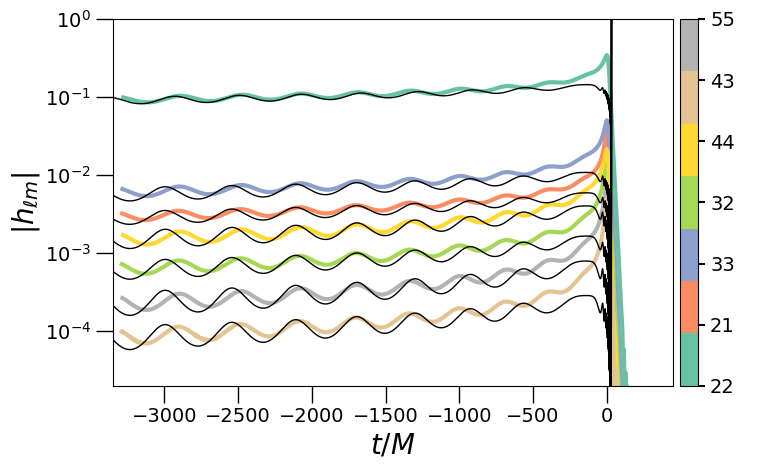

In [49]:
#plt.figure(figsize=(12,7))
plt.figure(figsize=(8.0,4.8))
N = 7
cmap = plt.get_cmap('Set2', N)
#colors = pl.cm.jet(np.linspace(0,1,N))
sm = plt.cm.ScalarMappable(cmap=cmap)#, norm=norm)
lw = [3.0,1]
plt.plot(tNR55- tNR55[np.argmax(NRamp55)] , NRamp55,linewidth = lw[0],c=cmap(6))
plt.plot(tNR21 - tNR21[np.argmax(NRamp21)] , NRamp21,linewidth = lw[0],c=cmap(1))
plt.plot(tNR33 - tNR33[np.argmax(NRamp33)] , NRamp33,linewidth = lw[0],c=cmap(2))
plt.plot(tNR32 - tNR32[np.argmax(NRamp32)] , NRamp32,linewidth = lw[0],c=cmap(3))
#plt.plot(tNR31 - tNR31[0] , NRamp31,linewidth = lw[0],c=cmap(4))
plt.plot(tNR44 - tNR44[np.argmax(NRamp44)] , NRamp44,linewidth = lw[0],c=cmap(4))
plt.plot(tNR43 - tNR43[np.argmax(NRamp43)] , NRamp43,linewidth = lw[0],c=cmap(5))
#plt.plot(tNR42 - tNR42[0] , NRamp42,linewidth = lw[0],c=cmap(7))
plt.plot(tNR22-tNR22[np.argmax(NRamp22)], NRamp22,linewidth = lw[0],c=cmap(0))
#plt.plot(tNR54 - tNR54[0] , NRamp54,linewidth = lw[0],c=cmap(7))
#plt.plot(tNR53 - tNR53[0] , NRamp53,linewidth = lw[0],c=cmap(10))
#plt.clim(21, 55)

#plt.colorbar(label="Mode", ticks = [21,22,32,33,43,44,54,55], orientation="vertical")
cbar = plt.colorbar(sm, ticks=np.linspace(0, 1, N),pad=0.01)
cbar.set_label(label=' ',size=15)
cbar.set_ticklabels(["22", "21", "33", "32","44","43","55"])
cbar.ax.tick_params(labelsize=14,width=1.5, length=5)
cbar.ax.tick_params(which="minor",width=1, length=0)


plt.plot(tPN55[:lst]-tPN55[np.argmax(PNamp55)] + 32,PNamp55[:lst],label='PN',linewidth = lw[1],color='black',linestyle='-')
plt.plot(tPN21[:lst]-tPN21[np.argmax(PNamp21)] + 32,PNamp21[:lst],linewidth = lw[1],color='black',linestyle='-')
plt.plot(tPN33[:lst]-tPN33[np.argmax(PNamp33)] + 32,PNamp33[:lst],linewidth = lw[1],color='black',linestyle='-')
plt.plot(tPN32[:lst]-tPN32[np.argmax(PNamp32)] + 32,PNamp32[:lst],linewidth = lw[1],color='black',linestyle='-')
#plt.plot(tPN31[:lst]-tPN31[np.argmax(PNamp31)]-50 + tNR31[np.argmax(NRamp31)],PNamp31[:lst],linewidth = lw[1],color='black',linestyle='-')
plt.plot(tPN44[:lst]-tPN44[np.argmax(PNamp44)] + 32,PNamp44[:lst],linewidth = lw[1],color='black',linestyle='-')
plt.plot(tPN43[:lst]-tPN43[np.argmax(PNamp43)] + 32,PNamp43[:lst],linewidth = lw[1],color='black',linestyle='-')
#plt.plot(tPN42[:lst]-tPN42[np.argmax(PNamp42)]-10 + tNR42[np.argmax(NRamp42)],PNamp42[:lst],linewidth = lw[1],color='black',linestyle='-')
plt.plot(tPN22[:lst]-tPN22[np.argmax(PNamp22)] + 32,PNamp22[:lst],linewidth = lw[1],color='black',linestyle='-')
#plt.plot(tPN54[:lst]-tPN54[np.argmax(PNamp54)] + tNR54[np.argmax(NRamp54)],PNamp54[:lst],linewidth = lw[1],color='black',linestyle='-')
#plt.plot(tPN53[:lst]-tPN53[np.argmax(PNamp53)]-10 + tNR53[np.argmax(NRamp53)],PNamp53[:lst],linewidth = lw[1],color='black',linestyle='-')

#print(tPN55[:lst]-tPN55[np.argmax(PNamp55)])

#np.savetxt('PN22.txt',np.c_[tPN55[:lst]-tPN55[np.argmax(PNamp55)] + 32 + tNR55[np.argmax(NRamp55)],PNamp55[:lst]])
#np.savetxt('NR22.txt',np.c_[tNR55 - tNR55[0],NRamp55])
#np.savetxt('formodel55.txt',np.c_[tPN55[:lst]-tPN55[np.argmax(PNamp55)] + 32,PNamp55[:lst]])


plt.ylim(ymax=1e0)
#plt.ylim(ymin=3e-6)
plt.ylim(ymin=2e-5)
plt.xlim(xmin=-3350)
plt.xlim(xmax=450)

plt.yscale('log')
#plt.title("PN-NR",fontsize=18)
#plt.ylabel(r"$\mathcal{A}_{\ell m}$", fontsize=30)
plt.ylabel(r"$|h_{\ell m}|$", fontsize=20,labelpad=2)
plt.xlabel(r"$t/M$", fontsize=20)
plt.minorticks_off()

#plt.grid()
#plt.legend(loc=2,ncol=2,prop={'size': 15},bbox_to_anchor=(1, 0.5))
#plt.legend(loc=2,ncol=2,prop={'size': 30})


from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D
from matplotlib.legend_handler import HandlerBase

class HandlerColormap(HandlerBase):
    def __init__(self, cmap, num_stripes=8, **kw):
        HandlerBase.__init__(self, **kw)
        self.cmap = cmap
        self.num_stripes = num_stripes
    def create_artists(self, legend, orig_handle, 
                       xdescent, ydescent, width, height, fontsize, trans):
        stripes = []
        for i in range(self.num_stripes):
            s = Rectangle([xdescent + i * width / self.num_stripes, ydescent+7], 
                          width / self.num_stripes, 
                          height/4.5, 
                          fc=self.cmap((2 * i + 1) / (2 * self.num_stripes)), 
                          transform=trans)
            stripes.append(s)
        return stripes

x_array = np.linspace(10000, 10001, 1)
y_array = x_array
param_max = x_array.size
cmaps = [plt.get_cmap('Set2', 7)]##)]#[plt.cm.Set2]  # set of colormaps 
                                        # (as many as there are groups of lines)

for param, (x, y) in enumerate(zip(x_array, y_array)):  
    x_line1 = np.linspace(x, 1.5 * x, 10)
    y_line1 = np.linspace(y**2, y**2 - x, 10)
    x_line2 = np.linspace(x, 1.5 * x, 10)
    y_line2 = np.linspace(y**2, y**2 - x, 10)

    # plot lines with color depending on param using different colormaps:
    plt.plot(x_line1, y_line1, c=cmaps[0](param / param_max))
    plt.plot(x_line2, y_line2)


lgd = Line2D([0], [0], color='black', lw=2)   
    
cmap_labels = ["NR","PN"]
# create proxy artists as handles:
#cmap_handles = [Rectangle((0, 0), 1, 1) for _ in cmaps]
cmap_handles = [Rectangle((0, 0), 1, 1)]
cmap_handles.append(lgd)
handler_map = dict(zip(cmap_handles, 
                       [HandlerColormap(cm, num_stripes=7) for cm in cmaps]))
#plt.legend(handles=cmap_handles, 
           #labels=cmap_labels, 
           #handler_map=handler_map,prop={'size': 30}, ncol = 2, loc=2)



#plt.savefig('amp_1364_new.pdf')

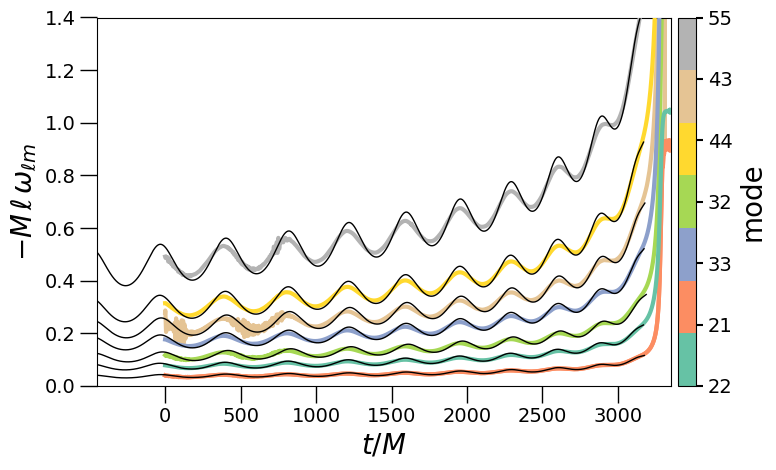

In [50]:
#plt.figure(figsize=(12,7))
plt.figure(figsize=(8,4.8))

N = 7
cmap = plt.get_cmap('Set2', N)
#colors = pl.cm.jet(np.linspace(0,1,N))
sm = plt.cm.ScalarMappable(cmap=cmap)#, norm=norm)

cbar = plt.colorbar(sm, ticks=np.linspace(0, 1, N),pad=0.01)
cbar.set_label(label='mode',size=20)
cbar.set_ticklabels(["22","21","33","32","44","43","55"])
cbar.ax.tick_params(labelsize=14,width=1.5, length=5)
cbar.ax.tick_params(which="minor",width=1, length=0)


plt.plot(tNR22 - tNR22[0], NRomega22*2,linewidth = 3.0,c=cmap(0),zorder=4)
plt.plot(tNR21 - tNR21[0], NRomega21*2,linewidth = 3.0,c=cmap(1),zorder=3)
plt.plot(tNR21 - tNR21[0], NRomega21*2,linewidth = 3.0,c=cmap(1),zorder=3)
plt.plot(tNR33 - tNR33[0], NRomega33*3,linewidth = 3.0,c=cmap(2),zorder=4)
plt.plot(tNR32 - tNR32[0], NRomega32*3,linewidth = 3.0,c=cmap(3),zorder=2)
#plt.plot(tNR31 - tNR31[0], NRomega31*3,linewidth = 3.0,c=cmap(4),zorder=2)
plt.plot(tNR44 - tNR44[0], NRomega44*4,linewidth = 3.0,c=cmap(4),zorder=4)
plt.plot(tNR43 - tNR43[0], NRomega43*4,linewidth = 3.0,c=cmap(5),zorder=1)  #[4100:]
#plt.plot(tNR42 - tNR42[0], NRomega42*4,linewidth = 3.0,c=cmap(7),zorder=1)
plt.plot(tNR55 - tNR55[0], NRomega55*5,linewidth = 3.0,c=cmap(6),zorder=4)
#plt.plot(tNR54 - tNR54[0], NRomega54*5,linewidth = 30,c=cmap(9),zorder=-1)  #[5600:]
#plt.plot(tNR53 - tNR53[0], NRomega53*5,linewidth = 3.0,c=cmap(10),zorder=0)

#print(NRomega21)
plt.plot(tPN22[:lst]-tPN22[np.argmax(PNamp22)]-110 + tNR22[np.argmax(NRamp22)],PNomega22[:lst]*2,linewidth = 1,color='black',linestyle='-',zorder=5)
plt.plot(tPN21[:lst]-tPN21[np.argmax(PNamp21)]-110 + tNR21[np.argmax(NRamp21)],PNomega21[:lst]*2,linewidth = 1,color='black',linestyle='-',zorder=5)
plt.plot(tPN33[:lst]-tPN33[np.argmax(PNamp33)]-110 + tNR33[np.argmax(NRamp33)],PNomega33[:lst]*3,linewidth = 1,color='black',linestyle='-',zorder=5)
plt.plot(tPN32[:lst]-tPN32[np.argmax(PNamp32)]-100 + tNR32[np.argmax(NRamp32)],PNomega32[:lst]*3,linewidth = 1,color='black',linestyle='-',zorder=5)
#plt.plot(tPN31[:lst]-tPN31[np.argmax(PNamp31)]-60 + tNR31[np.argmax(NRamp31)],PNomega31[:lst]*3,linewidth = 1,color='black',linestyle='-',zorder=5)
plt.plot(tPN44[:lst]-tPN44[np.argmax(PNamp44)]-110 + tNR44[np.argmax(NRamp44)],PNomega44[:lst]*4,linewidth = 1,color='black',linestyle='-',zorder=5)
plt.plot(tPN43[:lst]-tPN43[np.argmax(PNamp43)]-110 + tNR43[np.argmax(NRamp43)],PNomega43[:lst]*4,linewidth = 1,color='black',linestyle='-',zorder=5)
#plt.plot(tPN42[:lst]-tPN42[np.argmax(PNamp42)]-60 + tNR42[np.argmax(NRamp42)],PNomega42[:lst]*4,linewidth = 1,color='black',linestyle='-',zorder=5)
plt.plot(tPN55[:lst]-tPN55[np.argmax(PNamp55)]-110 + tNR55[np.argmax(NRamp55)],PNomega55[:lst]*5,linewidth = 1,color='black',linestyle='-',zorder=5)
#plt.plot(tPN54[:lst]-tPN54[np.argmax(PNamp54)]-60 + tNR54[np.argmax(NRamp54)],PNomega54[:lst]*5,linewidth = 1,color='black',linestyle='-',zorder=5)
#plt.plot(tPN53[:lst]-tPN53[np.argmax(PNamp53)]-60 + tNR53[np.argmax(NRamp53)],PNomega53[:lst]*5,linewidth = 1,color='black',linestyle='-',zorder=5)


#np.savetxt('pn22.txt',np.c_[tPN55[:lst]-tPN55[np.argmax(PNamp55)]-60 + tNR55[np.argmax(NRamp55)],PNomega55[:lst]*2])
#np.savetxt('nr22.txt',np.c_[tNR55 - tNR55[0],NRomega55*2])


#plt.yscale('log')
plt.ylim(ymax=1.4e0)
#plt.ylim(ymin=2.5e-2)


#plt.ylim(ymax=1.5)
plt.ylim(ymin=0.0)
plt.xlim(xmin=-450)
plt.xlim(xmax=3350)
#plt.title("PN-NR",fontsize=18)
plt.ylabel(r"$- M \, \ell \, \omega_{\ell m} $", fontsize=20)
plt.xlabel(r"$t/M$", fontsize=20)
plt.minorticks_off()
#plt.grid()
#plt.legend(loc=2,ncol=2,prop={'size': 15},bbox_to_anchor=(1, 0.5))
#plt.legend(loc=2,prop={'size': 30})

from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D
from matplotlib.legend_handler import HandlerBase

class HandlerColormap(HandlerBase):
    def __init__(self, cmap, num_stripes=8, **kw):
        HandlerBase.__init__(self, **kw)
        self.cmap = cmap
        self.num_stripes = num_stripes
    def create_artists(self, legend, orig_handle, 
                       xdescent, ydescent, width, height, fontsize, trans):
        stripes = []
        for i in range(self.num_stripes):
            s = Rectangle([xdescent + i * width / self.num_stripes, ydescent+7], 
                          width / self.num_stripes, 
                          height/4.5, 
                          fc=self.cmap((2 * i + 1) / (2 * self.num_stripes)), 
                          transform=trans)
            stripes.append(s)
        return stripes

x_array = np.linspace(10000, 10001, 1)
y_array = x_array
param_max = x_array.size
cmaps = [plt.get_cmap('Set2', 7)]#[plt.cm.Set2]  # set of colormaps 
                                        # (as many as there are groups of lines)

for param, (x, y) in enumerate(zip(x_array, y_array)):  
    x_line1 = np.linspace(x, 1.5 * x, 10)
    y_line1 = np.linspace(y**2, y**2 - x, 10)
    x_line2 = np.linspace(x, 1.5 * x, 10)
    y_line2 = np.linspace(y**2, y**2 - x, 10)

    # plot lines with color depending on param using different colormaps:
    plt.plot(x_line1, y_line1, c=cmaps[0](param / param_max))
    plt.plot(x_line2, y_line2)


lgd = Line2D([0], [0], color='black', lw=1)   
    
cmap_labels = ["NR","PN"]
# create proxy artists as handles:
#cmap_handles = [Rectangle((0, 0), 1, 1) for _ in cmaps]
cmap_handles = [Rectangle((0, 0), 1, 1)]
cmap_handles.append(lgd)
handler_map = dict(zip(cmap_handles, 
                       [HandlerColormap(cm, num_stripes=7) for cm in cmaps]))
#plt.legend(handles=cmap_handles, 
           #labels=cmap_labels, 
           #handler_map=handler_map,bbox_to_anchor=(0.02,0.96),prop={'size': 18}, ncol = 2, loc=2)

#plt.savefig('omega_1364_new_0.125.pdf')

In [51]:
# 'virdis' is not a valid value for name; supported values are 'Accent', 
#'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'BrBG_r', 'BuGn', 'BuGn_r', 'BuPu', 
#'BuPu_r', 'CMRmap', 'CMRmap_r', 'Dark2', 'Dark2_r', 'GnBu', 'GnBu_r', 'Greens', 
#'Greens_r', 'Greys', 'Greys_r', 'OrRd', 'OrRd_r', 'Oranges', 'Oranges_r', 'PRGn', 
#'PRGn_r', 'Paired', 'Paired_r', 'Pastel1', 'Pastel1_r', 'Pastel2', 'Pastel2_r', 'PiYG', 
#'PiYG_r', 'PuBu', 'PuBuGn', 'PuBuGn_r', 'PuBu_r', 'PuOr', 'PuOr_r', 'PuRd', 'PuRd_r', 'Purples', 
#'Purples_r', 'RdBu', 'RdBu_r', 'RdGy', 'RdGy_r', 'RdPu', 'RdPu_r', 'RdYlBu', 'RdYlBu_r', 
#'RdYlGn', 'RdYlGn_r', 'Reds', 'Reds_r', 'Set1', 'Set1_r', 'Set2', 'Set2_r', 'Set3', 'Set3_r', 
#'Spectral', 'Spectral_r', 'Wistia', 'Wistia_r', 'YlGn', 'YlGnBu', 'YlGnBu_r', 'YlGn_r', 
#'YlOrBr', 'YlOrBr_r', 'YlOrRd', 'YlOrRd_r', 'afmhot', 'afmhot_r', 'autumn', 'autumn_r', 
#'binary', 'binary_r', 'bone', 'bone_r', 'brg', 'brg_r', 'bwr', 'bwr_r', 'cividis', 'cividis_r',
#'cool', 'cool_r', 'coolwarm', 'coolwarm_r', 'copper', 'copper_r', 'cubehelix', 'cubehelix_r', 
#'flag', 'flag_r', 'gist_earth', 'gist_earth_r', 'gist_gray', 'gist_gray_r', 'gist_heat', 
#'gist_heat_r', 'gist_ncar', 'gist_ncar_r', 'gist_rainbow', 'gist_rainbow_r', 'gist_stern', 
#'gist_stern_r', 'gist_yarg', 'gist_yarg_r', 'gnuplot', 'gnuplot2', 'gnuplot2_r', 'gnuplot_r',
#'gray', 'gray_r', 'hot', 'hot_r', 'hsv', 'hsv_r', 'inferno', 'inferno_r', 'jet', 'jet_r', 
#'magma', 'magma_r', 'nipy_spectral', 'nipy_spectral_r', 'ocean', 'ocean_r', 'pink', 'pink_r',
#'plasma', 'plasma_r', 'prism', 'prism_r', 'rainbow', 'rainbow_r', 'seismic', 'seismic_r', 'spring',
#'spring_r', 'summer', 'summer_r', 'tab10', 'tab10_r', 'tab20', 'tab20_r', 'tab20b', 'tab20b_r', 
#'tab20c', 'tab20c_r', 'terrain', 'terrain_r', 'turbo', 'turbo_r', 'twilight', 'twilight_r', 
#'twilight_shifted', 'twilight_shifted_r', 'viridis', 'viridis_r', 'winter', 'winter_r'


# 22 Mode comparison

# Two dataset obtained for good PN-NR by varying frequency over one or two cycles...

* $e_0=0.1690976551797787$ at $f_0$ = 13.3 Hz

* $e_0=0.125$ at $f_0$ = 20 Hz

In [64]:
#New part
q=2 #mass ratio
M=30 #Total mass
nu=q/(1+q)**2
M1=q*M/(1+q)
M2=M/(1+q)
M_SI=M*MSUN_SI
D_SI=(10**6)*PC_SI
delta_t=1./4096
xlow=0.045
fmin= (xlow**(3/2)/(M*MTSUN_SI*math.pi))  #13.3 #22 #13.3 #20
e0 =  0.125310221261021  #0.125 #0.1690976551797787   #0.13362721511529033 #0.1675999999999996 #0.169 #120
l0 =-0.181
modetopolfac=4*(5/(64*np.pi))**(1/2)
Hp,Hc=get_td_waveform(approximant='EccentricTD',mass1=M1,mass2=M2,delta_t=delta_t,f_lower=fmin,eccentricity=e0,mean_per_ano=l0) 
Amp22 = waveform.utils.amplitude_from_polarizations(Hp/(modetopolfac*(G_SI*M_SI/D_SI/C_SI/C_SI)), Hc/(modetopolfac*(G_SI*M_SI/D_SI/C_SI/C_SI)))
phase_EccTD = waveform.utils.phase_from_polarizations(Hp/(modetopolfac*(G_SI*M_SI/D_SI/C_SI/C_SI)), Hc/(modetopolfac*(G_SI*M_SI/D_SI/C_SI/C_SI)))
tvec=Hp.sample_times/(M*MTSUN_SI) 

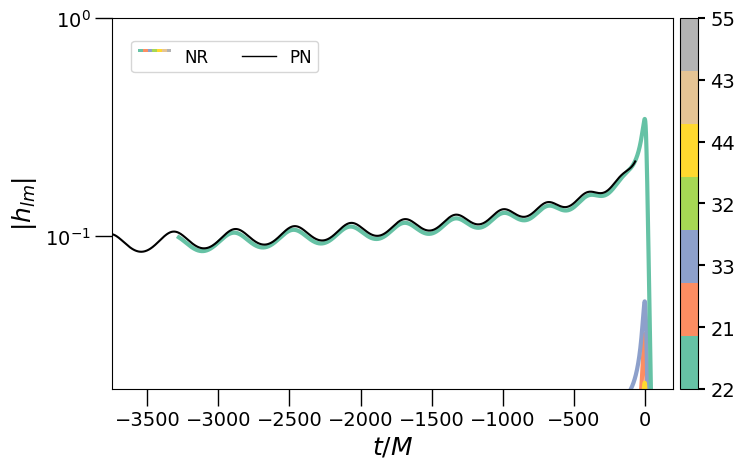

In [65]:
M0=M
M_SI=M0 * MSUN_SI
D_SI=(10**(6)) * PC_SI * 1
plt.figure(figsize=(8,4.8))
N = 7
cmap = plt.get_cmap('Set2', N)
sm = plt.cm.ScalarMappable(cmap=cmap)#, norm=norm)

cbar = plt.colorbar(sm, ticks=np.linspace(0, 1, N),pad=0.01)
cbar.set_ticklabels(["22","21","33","32","44","43","55"])
cbar.ax.tick_params(labelsize=14,width=1.5, length=5)
cbar.ax.tick_params(which="minor",width=1, length=0)


# Do calculate match 
#for i in range(0,200):
    




#NR data
plt.plot(tNR55- tNR55[np.argmax(NRamp55)] , NRamp55,linewidth = lw[0],c=cmap(6))
plt.plot(tNR21 - tNR21[np.argmax(NRamp21)] , NRamp21,linewidth = lw[0],c=cmap(1))
plt.plot(tNR33 - tNR33[np.argmax(NRamp33)] , NRamp33,linewidth = lw[0],c=cmap(2))
plt.plot(tNR32 - tNR32[np.argmax(NRamp32)] , NRamp32,linewidth = lw[0],c=cmap(3))
#plt.plot(tNR31 - tNR31[0] , NRamp31,linewidth = lw[0],c=cmap(4))
plt.plot(tNR44 - tNR44[np.argmax(NRamp44)] , NRamp44,linewidth = lw[0],c=cmap(4))
plt.plot(tNR43 - tNR43[np.argmax(NRamp43)] , NRamp43,linewidth = lw[0],c=cmap(5))
#plt.plot(tNR42 - tNR42[0] , NRamp42,linewidth = lw[0],c=cmap(7))
plt.plot(tNR22-tNR22[np.argmax(NRamp22)], NRamp22,linewidth = lw[0],c=cmap(0))
#plt.plot(tNR54 - tNR54[0] , NRamp54,linewidth = lw[0],c=cmap(7))
#plt.plot(tNR53 - tNR53[0] , NRamp53,linewidth = lw[0],c=cmap(10))
#plt.clim(21, 55)

#PN data


# interpolation for diff
#INTRP_NR = interp1d(c22-c22[np.where(d22==max(d22))[0][0]],d22,kind='cubic',fill_value='extrapolate')
#INTRP_PN = interp1d(tvec-60,Amp22,kind='cubic',fill_value='extrapolate') #for new case use the additional time shift
#tvec_range = np.linspace(-2500,-1000,500)
#NR_22_Amp = INTRP_NR(tvec_range)
#PN_22_Amp = INTRP_PN(tvec_range)
#Diff_new = abs(NR_22_Amp-PN_22_Amp)
#np.savetxt('Diff_new.txt',Diff_new)

#plt.plot(tvec_range,NR_22_Amp,c=cmap(0),linewidth=3.0)
#plt.plot(tvec_range,PN_22_Amp,'k-')    
plt.semilogy(tvec-65,Amp22,'k-',label='EccTD') #tvec-120,60,12

#print(len(Amp22),len(d22))

plt.ylim(ymax=1e0)
#plt.ylim(ymin=3e-6)
plt.ylim(ymin=2e-2)
plt.xlim(xmin=-3750)
plt.xlim(xmax=200)
plt.ylabel(r'$|h_{lm}|$',size=18)
plt.xlabel(r'$t/M$',size=18)
plt.yscale('log')


plt.minorticks_off()
from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D
from matplotlib.legend_handler import HandlerBase
class HandlerColormap(HandlerBase):
    def __init__(self, cmap, num_stripes=8, **kw):
        HandlerBase.__init__(self, **kw)
        self.cmap = cmap
        self.num_stripes = num_stripes
    def create_artists(self, legend, orig_handle, 
                       xdescent, ydescent, width, height, fontsize, trans):
        stripes = []
        for i in range(self.num_stripes):
            s = Rectangle([xdescent + i * width / self.num_stripes, ydescent+7], 
                          width / self.num_stripes, 
                          height/4.5, 
                          fc=self.cmap((2 * i + 1) / (2 * self.num_stripes)), 
                          transform=trans)
            stripes.append(s)
        return stripes

x_array = np.linspace(10000, 10001, 1)
y_array = x_array
param_max = x_array.size
cmaps = [plt.get_cmap('Set2', 7)]#[plt.cm.Set2]  # set of colormaps 
                                        # (as many as there are groups of lines)

for param, (x, y) in enumerate(zip(x_array, y_array)):  
    x_line1 = np.linspace(x, 1.5 * x, 10)
    y_line1 = np.linspace(y**2, y**2 - x, 10)
    x_line2 = np.linspace(x, 1.5 * x, 10)
    y_line2 = np.linspace(y**2, y**2 - x, 10)

    # plot lines with color depending on param using different colormaps:
    plt.plot(x_line1, y_line1, c=cmaps[0](param / param_max))
    plt.plot(x_line2, y_line2)


lgd = Line2D([0], [0], color='black', lw=1)   
    
cmap_labels = ["NR","PN"]
cmap_handles = [Rectangle((0, 0), 1, 1)]
cmap_handles.append(lgd)
handler_map = dict(zip(cmap_handles, 
                       [HandlerColormap(cm, num_stripes=7) for cm in cmaps]))
plt.legend(handles=cmap_handles, 
           labels=cmap_labels, 
           handler_map=handler_map,bbox_to_anchor=(0.02,0.96),prop={'size': 12}, ncol = 2, loc=2)




#plt.savefig('Amplitude_0.125.pdf',dpi=600)
plt.show()

In [66]:


omegaEcc22 = (M*MTSUN_SI/delta_t)*(np.gradient(phase_EccTD))
omegaEcc21 = (M*MTSUN_SI/delta_t)*(np.gradient(phase_EccTD*(1./2)))
omegaEcc33 = (M*MTSUN_SI/delta_t)*(np.gradient(phase_EccTD*(3./2)))
omegaEcc44 = (M*MTSUN_SI/delta_t)*(np.gradient(phase_EccTD*(4./2)))
omegaEcc43 = (M*MTSUN_SI/delta_t)*(np.gradient(phase_EccTD*(3./2)))
omegaEcc32 = (M*MTSUN_SI/delta_t)*(np.gradient(phase_EccTD*(2./2)))
omegaEcc55 = (M*MTSUN_SI/delta_t)*(np.gradient(phase_EccTD*(5./2)))

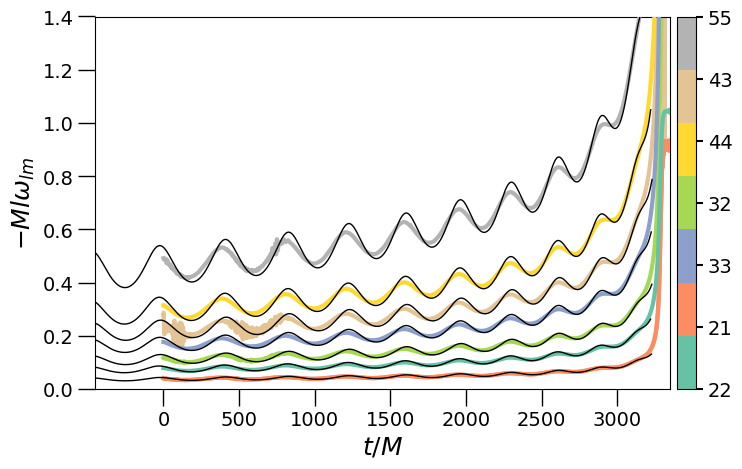

In [67]:
plt.figure(figsize=(8,4.8))
N = 7
cmap = plt.get_cmap('Set2', N)
sm = plt.cm.ScalarMappable(cmap=cmap)#, norm=norm)

cbar = plt.colorbar(sm, ticks=np.linspace(0, 1, N),pad=0.01)
#cbar.set_label(label='mode',size=20)
cbar.set_ticklabels(["22","21","33","32","44","43","55"])
cbar.ax.tick_params(labelsize=14,width=1.5, length=5)
cbar.ax.tick_params(which="minor",width=1, length=0)


plt.plot(tNR22 - tNR22[0], NRomega22*2,linewidth = 3.0,c=cmap(0),zorder=4)
plt.plot(tNR21 - tNR21[0], NRomega21*2,linewidth = 3.0,c=cmap(1),zorder=3)
plt.plot(tNR21 - tNR21[0], NRomega21*2,linewidth = 3.0,c=cmap(1),zorder=3)
plt.plot(tNR33 - tNR33[0], NRomega33*3,linewidth = 3.0,c=cmap(2),zorder=4)
plt.plot(tNR32 - tNR32[0], NRomega32*3,linewidth = 3.0,c=cmap(3),zorder=2)
#plt.plot(tNR31 - tNR31[0], NRomega31*3,linewidth = 3.0,c=cmap(4),zorder=2)
plt.plot(tNR44 - tNR44[0], NRomega44*4,linewidth = 3.0,c=cmap(4),zorder=4)
plt.plot(tNR43 - tNR43[0], NRomega43*4,linewidth = 3.0,c=cmap(5),zorder=1)  #[4100:]
#plt.plot(tNR42 - tNR42[0], NRomega42*4,linewidth = 3.0,c=cmap(7),zorder=1)
plt.plot(tNR55 - tNR55[0], NRomega55*5,linewidth = 3.0,c=cmap(6),zorder=4)
#plt.plot(tNR54 - tNR54[0], NRomega54*5,linewidth = 30,c=cmap(9),zorder=-1)  #[5600:]
#plt.plot(tNR53 - tNR53[0], NRomega53*5,linewidth = 3.0,c=cmap(10),zorder=0)


plt.plot(tvec-tvec[np.argmax(Amp22)]-60+tNR22[np.argmax(NRamp22)],2*omegaEcc22,'k',linewidth = 1,linestyle='-',zorder=5)
plt.plot(tvec-tvec[np.argmax(Amp22)]-60+tNR22[np.argmax(NRamp21)],2*omegaEcc21,'k',linewidth = 1,linestyle='-',zorder=5) #120
plt.plot(tvec-tvec[np.argmax(Amp22)]-60+tNR22[np.argmax(NRamp33)],3*omegaEcc33,'k',linewidth = 1,linestyle='-',zorder=5)
plt.plot(tvec-tvec[np.argmax(Amp22)]-60+tNR22[np.argmax(NRamp44)],4*omegaEcc44,'k',linewidth = 1,linestyle='-',zorder=5)
plt.plot(tvec-tvec[np.argmax(Amp22)]-60+tNR22[np.argmax(NRamp43)],4*omegaEcc43,'k',linewidth = 1,linestyle='-',zorder=5)
plt.plot(tvec-tvec[np.argmax(Amp22)]-60+tNR22[np.argmax(NRamp32)],3*omegaEcc32,'k',linewidth = 1,linestyle='-',zorder=5)
plt.plot(tvec-tvec[np.argmax(Amp22)]-60+tNR22[np.argmax(NRamp55)],5*omegaEcc55,'k',linewidth = 1,linestyle='-',zorder=5)

# -60


plt.ylim(ymax=1.4e0)
plt.ylim(ymin=0.0)
plt.xlim(xmin=-450)
plt.xlim(xmax=3350)
plt.ylabel(r'$-Ml\omega_{lm}$',size=18)
plt.xlabel(r'$t/M$',size=18)
#plt.yscale('log')
#plt.savefig("update_PN-NR freq.png",dpi=300)

plt.show()

In [56]:
#New part
q=2 #mass ratio
M=30 #Total mass
nu=q/(1+q)**2
M1=q*M/(1+q)
M2=M/(1+q)
M_SI=M*MSUN_SI
D_SI=(10**6)*PC_SI
delta_t=1./4096
fmin= 13.3 #22 #13.3 #20
e0 = 0.1690976551797787 #0.0605 #0.169 #120
l0 = 2.780044681706199 #-0.181
modetopolfac=4*(5/(64*np.pi))**(1/2)
Hp,Hc=get_td_waveform(approximant='EccentricTD',mass1=M1,mass2=M2,delta_t=delta_t,f_lower=fmin,eccentricity=e0,mean_per_ano=l0) 
Amp22 = waveform.utils.amplitude_from_polarizations(Hp/(modetopolfac*(G_SI*M_SI/D_SI/C_SI/C_SI)), Hc/(modetopolfac*(G_SI*M_SI/D_SI/C_SI/C_SI)))
phase_EccTD = waveform.utils.phase_from_polarizations(Hp/(modetopolfac*(G_SI*M_SI/D_SI/C_SI/C_SI)), Hc/(modetopolfac*(G_SI*M_SI/D_SI/C_SI/C_SI)))
tvec=Hp.sample_times/(M*MTSUN_SI) 

First we check the value of e0 for which the mismatch is the lowest for fmin = 20. We get e0 = 0.12200000000000001
Secondly we check the value of e0 for which the mismatch is the lowest for fmin = 13.3. We get e0 = 0.1675999999999996

In [57]:
#for i in tqdm(arange(0.169,0.170,0.001)):
M = []
K=[]
for k in tqdm(np.arange(0.11,0.17,0.001)):#(np.arange(0.164,0.170,0.0001)):
        Hp,Hc=get_td_waveform(approximant='EccentricTD',mass1=M1,mass2=M2,delta_t=delta_t,f_lower=fmin,eccentricity=k,mean_per_ano=l0)
        Sp = TimeSeries(hp_NR_int,delta_t,epoch=0)

        #Sp=hpVec_NR
        # Resize the waveforms to the same length
        tlen = max(len(Sp), len(Hp))
        Sp.resize(tlen)
        Hp.resize(tlen)
        # Generate the aLIGO ZDHP PSD
        #delta_f = 1.0 /Sp.duration 
        delta_f = 1.0/(Sp.duration)
        flen = tlen//2 + 1
        f_low = fmin
        psd = aLIGOZeroDetHighPower(flen, delta_f, f_low)
        # Note: This takes a while the first time as an FFT plan is generated
        # subsequent calls are much faster.
        m, i = match(Hp, Sp, psd=psd, low_frequency_cutoff=f_low)
        mismatch=1-m
        M.append(mismatch)
        K.append(k)
        print(k,mismatch)

  2%|▋                                           | 1/61 [00:00<00:24,  2.41it/s]

0.11 0.6929529727721642


  3%|█▍                                          | 2/61 [00:00<00:24,  2.46it/s]

0.111 0.6995997439659103


  5%|██▏                                         | 3/61 [00:01<00:24,  2.41it/s]

0.112 0.7043528525720929


  7%|██▉                                         | 4/61 [00:01<00:24,  2.36it/s]

0.113 0.7041406620199018


  8%|███▌                                        | 5/61 [00:02<00:22,  2.48it/s]

0.114 0.7025549828194793


 10%|████▎                                       | 6/61 [00:02<00:21,  2.55it/s]

0.115 0.7008375335633468


 11%|█████                                       | 7/61 [00:02<00:20,  2.58it/s]

0.116 0.7012971142512763


 13%|█████▊                                      | 8/61 [00:03<00:20,  2.60it/s]

0.117 0.7013616767688442


 15%|██████▍                                     | 9/61 [00:03<00:19,  2.63it/s]

0.11800000000000001 0.6949011792981338


 16%|███████                                    | 10/61 [00:03<00:19,  2.63it/s]

0.11900000000000001 0.6857683528820482


 18%|███████▊                                   | 11/61 [00:04<00:18,  2.66it/s]

0.12000000000000001 0.678098519218256


 20%|████████▍                                  | 12/61 [00:04<00:18,  2.67it/s]

0.12100000000000001 0.6767115186612229


 21%|█████████▏                                 | 13/61 [00:05<00:17,  2.68it/s]

0.12200000000000001 0.6790045763546017


 23%|█████████▊                                 | 14/61 [00:05<00:17,  2.68it/s]

0.12300000000000001 0.6881680024149135


 25%|██████████▌                                | 15/61 [00:05<00:17,  2.68it/s]

0.12400000000000001 0.6937242618905943


 26%|███████████▎                               | 16/61 [00:06<00:16,  2.71it/s]

0.125 0.6988094511341278


 28%|███████████▉                               | 17/61 [00:06<00:16,  2.72it/s]

0.126 0.7010979661346768


 30%|████████████▋                              | 18/61 [00:06<00:15,  2.71it/s]

0.127 0.7046225355765662


 31%|█████████████▍                             | 19/61 [00:07<00:15,  2.70it/s]

0.128 0.7070595557967438


 33%|██████████████                             | 20/61 [00:07<00:15,  2.63it/s]

0.129 0.7090565920049592


 34%|██████████████▊                            | 21/61 [00:08<00:15,  2.58it/s]

0.13 0.7039421856439382


 36%|███████████████▌                           | 22/61 [00:08<00:15,  2.57it/s]

0.131 0.6929228562834109


 38%|████████████████▏                          | 23/61 [00:08<00:14,  2.62it/s]

0.132 0.6828158513815394


 39%|████████████████▉                          | 24/61 [00:09<00:14,  2.60it/s]

0.133 0.6784826552958706


 41%|█████████████████▌                         | 25/61 [00:09<00:14,  2.53it/s]

0.134 0.6795732049451071


 43%|██████████████████▎                        | 26/61 [00:10<00:14,  2.46it/s]

0.135 0.6840149487027759


 44%|███████████████████                        | 27/61 [00:10<00:13,  2.45it/s]

0.136 0.6866981720230848


 46%|███████████████████▋                       | 28/61 [00:10<00:12,  2.54it/s]

0.137 0.6904565349384479


 48%|████████████████████▍                      | 29/61 [00:11<00:12,  2.59it/s]

0.138 0.6973168377637319


 49%|█████████████████████▏                     | 30/61 [00:11<00:11,  2.63it/s]

0.139 0.7068430399013088


 51%|█████████████████████▊                     | 31/61 [00:11<00:11,  2.67it/s]

0.14 0.7135449767150985


 52%|██████████████████████▌                    | 32/61 [00:12<00:10,  2.66it/s]

0.14100000000000001 0.7120995435792778


 54%|███████████████████████▎                   | 33/61 [00:12<00:10,  2.59it/s]

0.14200000000000002 0.7024567589228792


 56%|███████████████████████▉                   | 34/61 [00:13<00:10,  2.56it/s]

0.14300000000000002 0.6922002990095801


 57%|████████████████████████▋                  | 35/61 [00:13<00:09,  2.66it/s]

0.14400000000000002 0.6871059914702693


 59%|█████████████████████████▍                 | 36/61 [00:13<00:09,  2.70it/s]

0.14500000000000002 0.6851176408546449


 61%|██████████████████████████                 | 37/61 [00:14<00:08,  2.73it/s]

0.14600000000000002 0.683257791666509


 62%|██████████████████████████▊                | 38/61 [00:14<00:08,  2.76it/s]

0.14700000000000002 0.6800210132630988


 64%|███████████████████████████▍               | 39/61 [00:14<00:07,  2.78it/s]

0.14800000000000002 0.6823232505053066


 66%|████████████████████████████▏              | 40/61 [00:15<00:07,  2.80it/s]

0.14900000000000002 0.6919056340072453


 67%|████████████████████████████▉              | 41/61 [00:15<00:07,  2.82it/s]

0.15000000000000002 0.7070543994370377


 69%|█████████████████████████████▌             | 42/61 [00:15<00:06,  2.84it/s]

0.15100000000000002 0.7156466662763105


 70%|██████████████████████████████▎            | 43/61 [00:16<00:06,  2.76it/s]

0.15200000000000002 0.7122395113773482


 72%|███████████████████████████████            | 44/61 [00:16<00:06,  2.79it/s]

0.15300000000000002 0.7037863808795095


 74%|███████████████████████████████▋           | 45/61 [00:17<00:05,  2.80it/s]

0.15400000000000003 0.6987625750285429


 75%|████████████████████████████████▍          | 46/61 [00:17<00:05,  2.80it/s]

0.15500000000000003 0.6956799507725884


 77%|█████████████████████████████████▏         | 47/61 [00:17<00:05,  2.78it/s]

0.15600000000000003 0.6883163305548986


 79%|█████████████████████████████████▊         | 48/61 [00:18<00:04,  2.78it/s]

0.15700000000000003 0.6782332470811838


 80%|██████████████████████████████████▌        | 49/61 [00:18<00:04,  2.78it/s]

0.15800000000000003 0.6739292332442967


 82%|███████████████████████████████████▏       | 50/61 [00:18<00:04,  2.70it/s]

0.15900000000000003 0.6832784771129481


 84%|███████████████████████████████████▉       | 51/61 [00:19<00:03,  2.65it/s]

0.16000000000000003 0.6972833050416357


 85%|████████████████████████████████████▋      | 52/61 [00:19<00:03,  2.60it/s]

0.16100000000000003 0.7110096810039833


 87%|█████████████████████████████████████▎     | 53/61 [00:20<00:03,  2.55it/s]

0.16200000000000003 0.7125997596207343


 89%|██████████████████████████████████████     | 54/61 [00:20<00:02,  2.64it/s]

0.16300000000000003 0.7089022309148375


 90%|██████████████████████████████████████▊    | 55/61 [00:20<00:02,  2.69it/s]

0.16400000000000003 0.7072031606112872


 92%|███████████████████████████████████████▍   | 56/61 [00:21<00:01,  2.76it/s]

0.16500000000000004 0.7043335973367527


 93%|████████████████████████████████████████▏  | 57/61 [00:21<00:01,  2.78it/s]

0.16600000000000004 0.6912076092532943


 95%|████████████████████████████████████████▉  | 58/61 [00:21<00:01,  2.82it/s]

0.16700000000000004 0.6770794537445013


 97%|█████████████████████████████████████████▌ | 59/61 [00:22<00:00,  2.82it/s]

0.16800000000000004 0.6728278025360694


 98%|██████████████████████████████████████████▎| 60/61 [00:22<00:00,  2.81it/s]

0.16900000000000004 0.681413871339184


100%|███████████████████████████████████████████| 61/61 [00:22<00:00,  2.67it/s]

0.17000000000000004 0.6931658463089369


In [58]:
np.where(M==np.min(M))[0][0]

58

In [59]:
K[40]

0.15000000000000002